# Домашнее задание 3

**Выполнил:** Сунцов Демид

**Задание:** Предсказать среднее время реакции в лингвистическом эксперименте (целевая переменная $-$ **RTlexdec**). Для этого создать наилучшую предсказательную модель с помощью алгоритма линейной регрессии.

**Что необходимо сделать:**

1) Исследуйте зависимость целевой переменной от исходных факторов и пар факторов, постройте диаграммы, отражающие эти зависимости.

2) Закодируйте категориальные признаки. Начните с **OneHotEncoding**, затем попробуйте счетчики.

3) Сделайте масштабирование данных.

4) Обучите линейную регрессию, посмотрите на качество <code>r2_score</code>.

5) Выведите на экран веса признаков, дайте интерпретацию этим весам.

6) Поработайте над созданием новых признаков (функции от исходных признаков, функции от пар признаков и т.д.). Добейтесь увеличения качества исходного алгоритма.

**Решение**

In [1]:
import warnings
warnings.filterwarnings('ignore')

Выгрузим необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
mpl.rcParams['figure.dpi'] = 300

Выгрузим датасет с данными по лингвистическому эксперименту из <code>.csv</code> файла.

In [4]:
df = pd.read_csv("class7_Baayen_et_al_2006.csv")
df.head()

RTlexdec  Familiarity AgeSubject  WrittenFrequency WordCategory  \
0  6.543754         2.37      young          3.912023            N   
1  6.397596         4.43      young          4.521789            N   
2  6.304942         5.60      young          6.505784            N   
3  6.424221         3.87      young          5.017280            N   
4  6.450597         3.93      young          4.890349            N   

   LengthInLetters  FrequencyInitialDiphoneWord  
0                3                    10.129308  
1                5                     9.054388  
2                6                    12.422026  
3                4                    10.048151  
4                4                    11.796336

Определим размер датасета <code>df</code>

In [5]:
df.shape

(4568, 7)

Изучим датасет, вызвав методы <code><font color='steelblue'>info</font></code> и <code><font color='steelblue'>describe</font></code>.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RTlexdec                     4568 non-null   float64
 1   Familiarity                  4568 non-null   float64
 2   AgeSubject                   4568 non-null   object 
 3   WrittenFrequency             4568 non-null   float64
 4   WordCategory                 4568 non-null   object 
 5   LengthInLetters              4568 non-null   int64  
 6   FrequencyInitialDiphoneWord  4568 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 249.9+ KB


Признаки **AgeSubject** и **WordCategory** являются категориальными, а остальные $-$ числовыми.

In [7]:
df.describe()

RTlexdec  Familiarity  WrittenFrequency  LengthInLetters  \
count  4568.000000  4568.000000       4568.000000      4568.000000   
mean      6.550097     3.795582          5.021145         4.342382   
std       0.156919     1.149326          1.843559         0.841828   
min       6.205325     1.100000          0.000000         2.000000   
25%       6.425525     3.000000          3.761200         4.000000   
50%       6.550466     3.700000          4.832298         4.000000   
75%       6.653211     4.570000          6.247074         5.000000   
max       7.187808     6.970000         11.356658         7.000000   

       FrequencyInitialDiphoneWord  
count                  4568.000000  
mean                     10.359055  
std                       1.583577  
min                       3.091042  
25%                       9.556808  
50%                      10.516509  
75%                      11.319947  
max                      13.924902

Убедимся, что в датасете нет пропущенных значений.

In [8]:
df.isna().sum()

RTlexdec                       0
Familiarity                    0
AgeSubject                     0
WrittenFrequency               0
WordCategory                   0
LengthInLetters                0
FrequencyInitialDiphoneWord    0
dtype: int64

Начнем с обработки категориальных признаков. Проанализируем признак **WordCategory**. Выведем уникальные значения признака

In [9]:
df['WordCategory'].unique()

array(['N', 'V'], dtype=object)

Как видно, в датасете представлены только существительные (<code>N</code> - noun) и глаголы (<code>V</code> - verb). Для кодирования данного категориального признака используем <code><font color=steelblue>map</font></code>

In [10]:
# N (noun) - 0
# V (verb) - 1
df['IsVerb'] = df['WordCategory'].map({'N' : 0, 'V' : 1})

In [11]:
df.drop(['WordCategory'], axis=1, inplace=True)
df.head()

RTlexdec  Familiarity AgeSubject  WrittenFrequency  LengthInLetters  \
0  6.543754         2.37      young          3.912023                3   
1  6.397596         4.43      young          4.521789                5   
2  6.304942         5.60      young          6.505784                6   
3  6.424221         3.87      young          5.017280                4   
4  6.450597         3.93      young          4.890349                4   

   FrequencyInitialDiphoneWord  IsVerb  
0                    10.129308       0  
1                     9.054388       0  
2                    12.422026       0  
3                    10.048151       0  
4                    11.796336       0

Теперь преобразуем признак **AgeSubject**. Выведем уникальные значения признака

In [12]:
df['AgeSubject'].unique()

array(['young', 'old'], dtype=object)

Снова применим процедуру кодирования.

In [13]:
# old - 0
# young - 1
df['IsYoung'] = df['AgeSubject'].map({'old' : 0, 'young' : 1})

In [14]:
df.drop(['AgeSubject'],axis=1, inplace=True)
df.head()

RTlexdec  Familiarity  WrittenFrequency  LengthInLetters  \
0  6.543754         2.37          3.912023                3   
1  6.397596         4.43          4.521789                5   
2  6.304942         5.60          6.505784                6   
3  6.424221         3.87          5.017280                4   
4  6.450597         3.93          4.890349                4   

   FrequencyInitialDiphoneWord  IsVerb  IsYoung  
0                    10.129308       0        1  
1                     9.054388       0        1  
2                    12.422026       0        1  
3                    10.048151       0        1  
4                    11.796336       0        1

In [15]:
df.dtypes

RTlexdec                       float64
Familiarity                    float64
WrittenFrequency               float64
LengthInLetters                  int64
FrequencyInitialDiphoneWord    float64
IsVerb                           int64
IsYoung                          int64
dtype: object

Итак, все категориальные признаки обработаны.

Теперь приступим к непосредственному анализу данных. Посмотрим, как влияет часть речи (обработанный признак **WordCategory**) на скорость восприятия, целевую переменную **RTlexdec**. Выведем количество уникальных значений признака **IsVerb**

In [16]:
df['IsVerb'].value_counts()

IsVerb
0    2904
1    1664
Name: count, dtype: int64

Сравним средние значения целевой переменной для существительных и глаголов. Существительные

In [17]:
nouns = df.loc[(df['IsVerb'] == 0)]
nouns['RTlexdec'].mean()

6.554757552607764

Глаголы

In [18]:
verbs = df.loc[(df['IsVerb'] == 1)]
verbs['RTlexdec'].mean()

6.541964464342036

Все вместе

In [19]:
df['RTlexdec'].mean()

6.550097373344593

Как видим, часть речи не влияет на среднее значение целевой переменной. Построим <code>sns.<font color='steelblue'>violinplot</font></code> для исследования зависимости **lexical decision time** от части речи

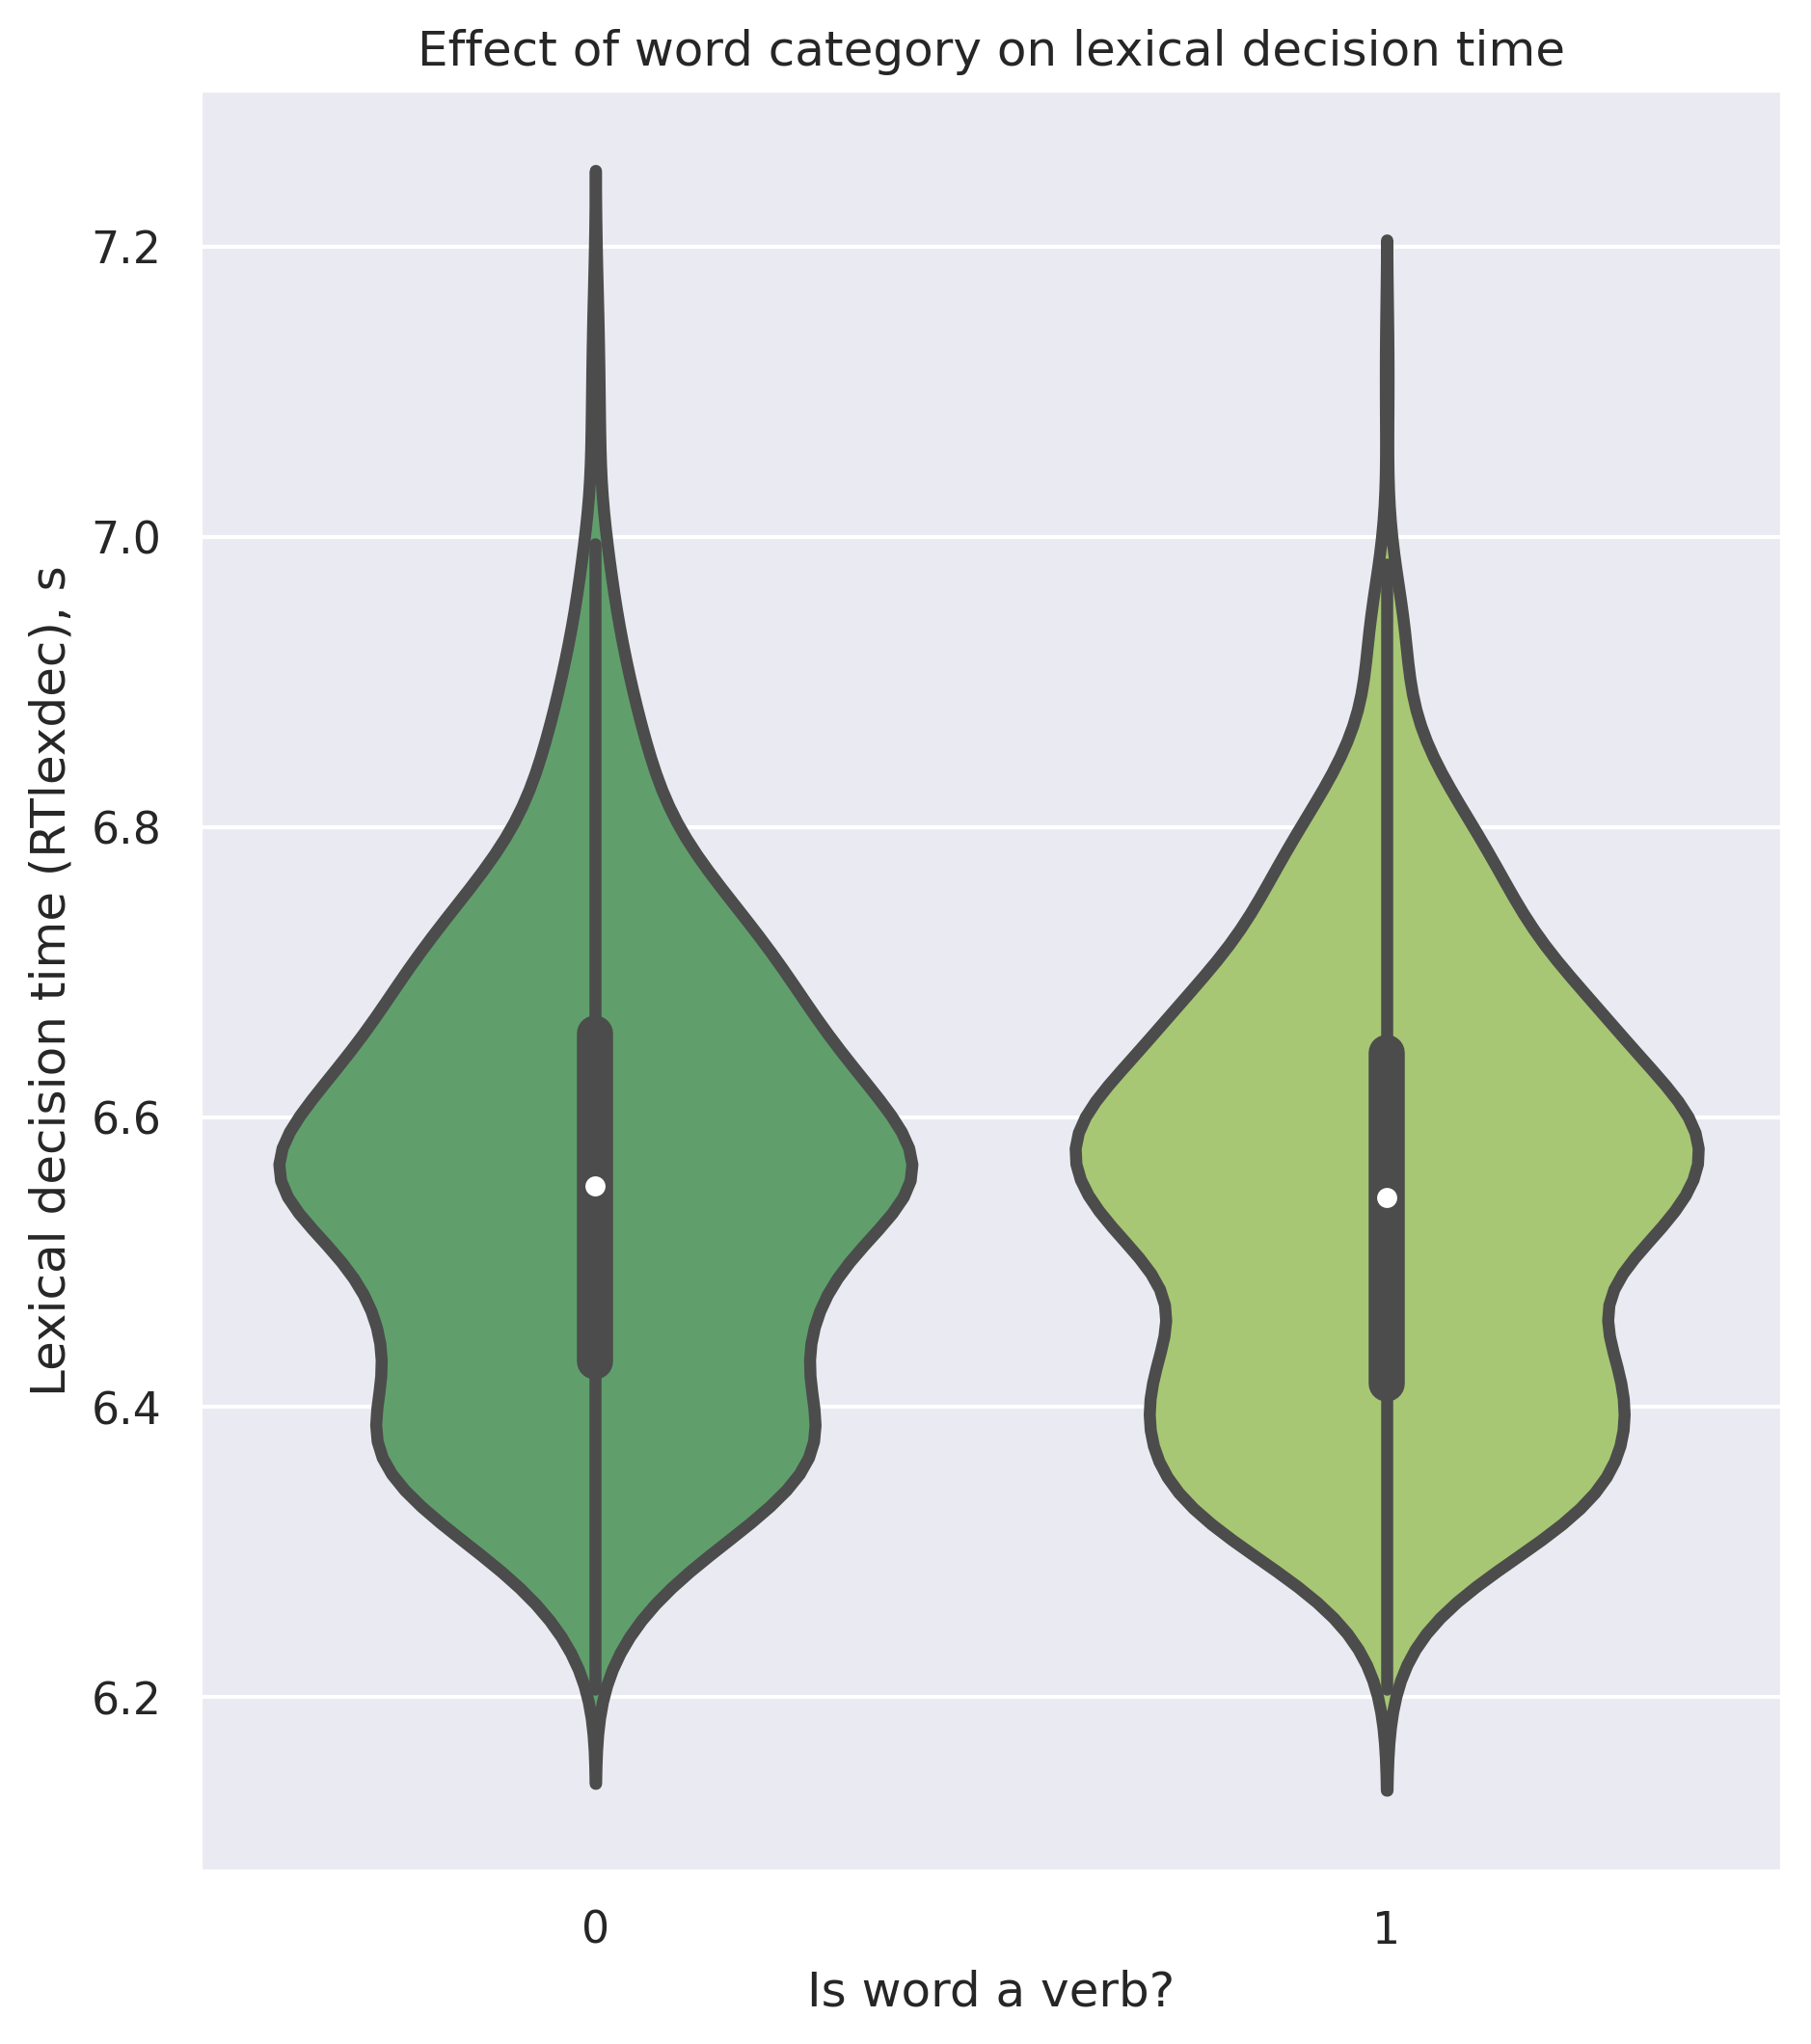

In [20]:
fig = plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
ax = sns.violinplot(data=df, x='IsVerb', y='RTlexdec', palette='summer', linewidth=3)
ax.set_title('Effect of word category on lexical decision time')
ax.set_xlabel('Is word a verb?')
ax.set_ylabel('Lexical decision time (RTlexdec), s')
plt.show()

Как видим, разницы между распределением слева и справа почти нет.

Теперь исследуем признак **LengthInLetters** (количество букв в слове).

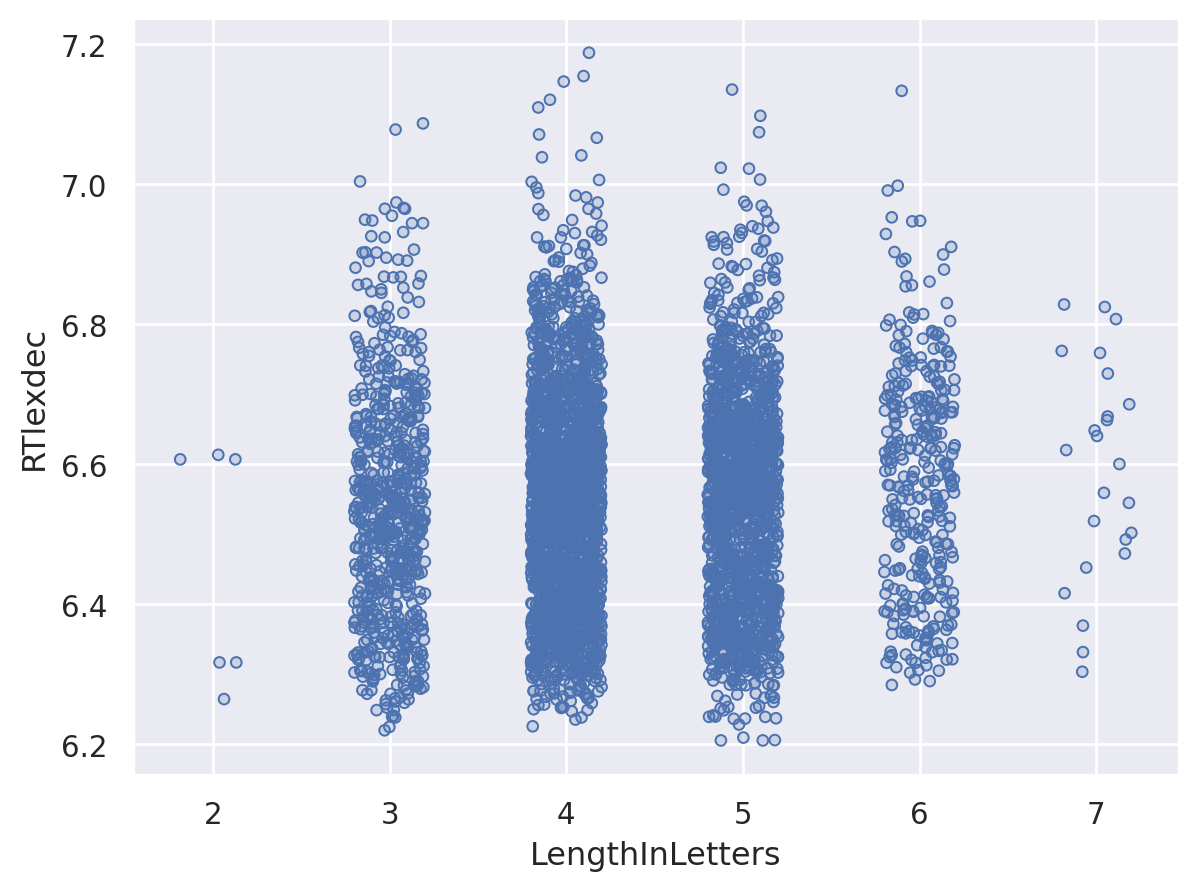

In [21]:
import seaborn.objects as so

sns.objects.Plot(df, x='LengthInLetters', y='RTlexdec').add(so.Dots(), so.Jitter(0.5))

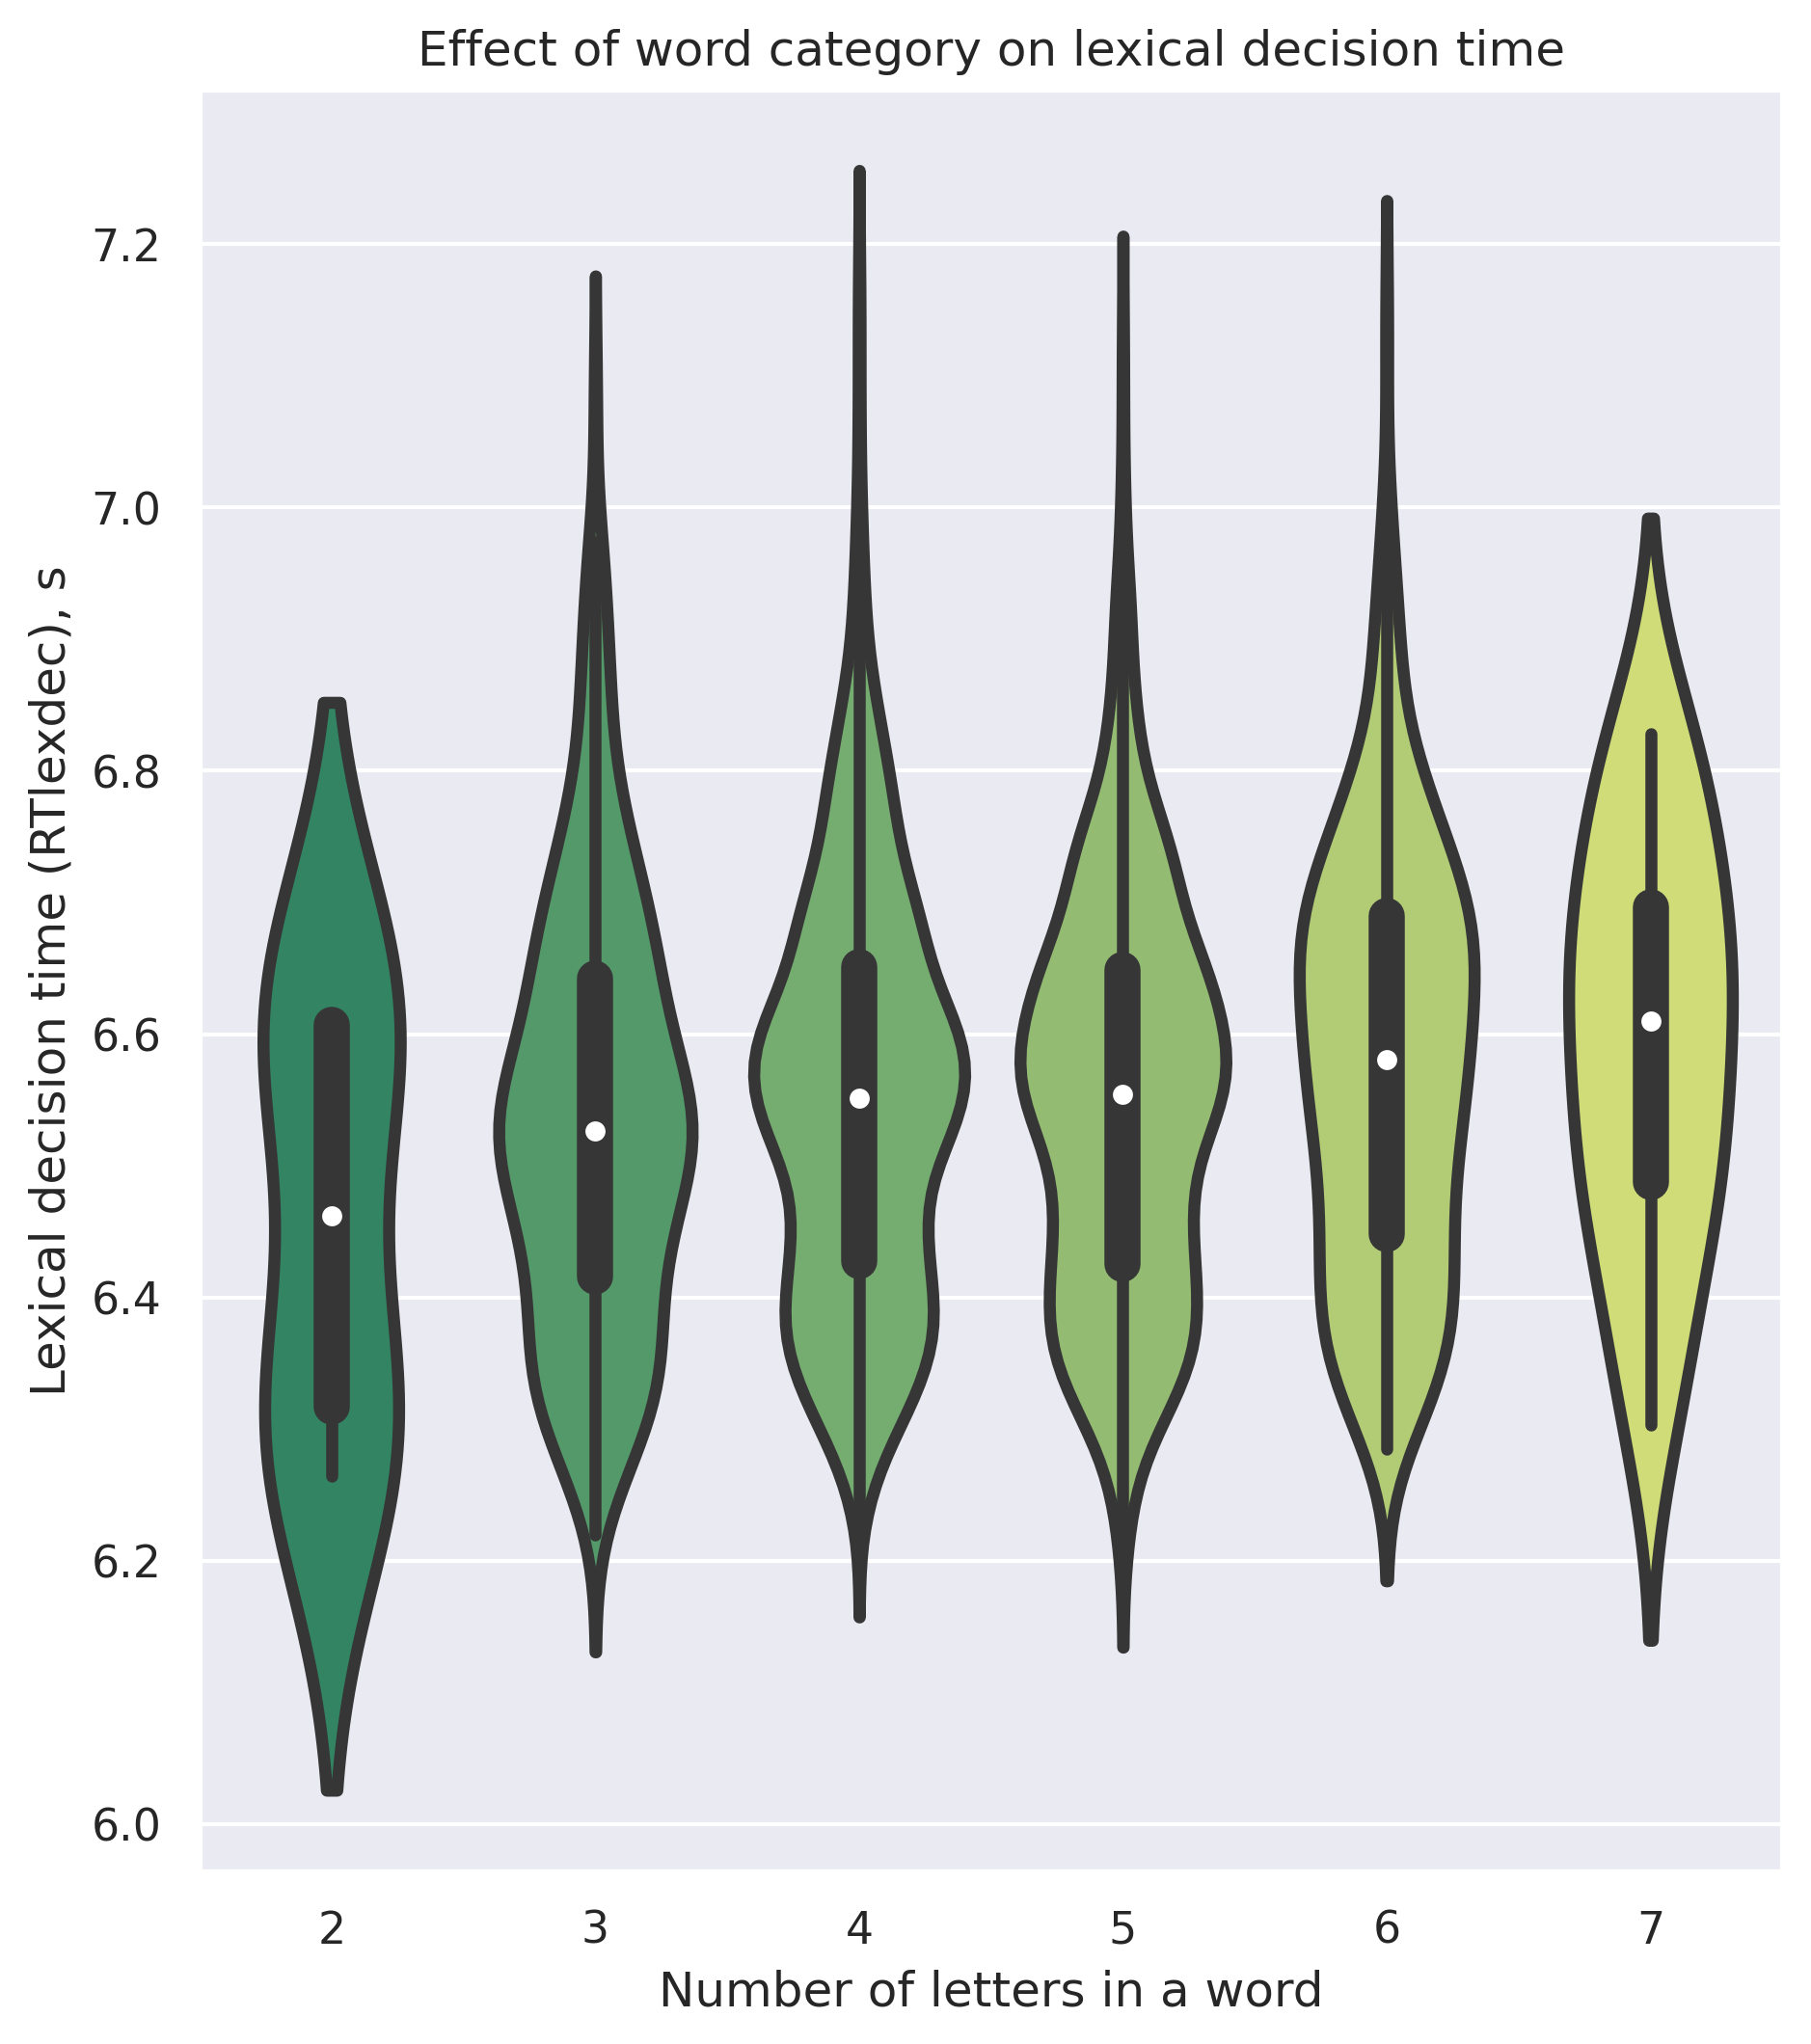

In [22]:
fig = plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
ax = sns.violinplot(data=df, x='LengthInLetters', y='RTlexdec', palette='summer', linewidth=3)
ax.set_title('Effect of word category on lexical decision time')
ax.set_xlabel('Number of letters in a word')
ax.set_ylabel('Lexical decision time (RTlexdec), s')
plt.show()

Видим, что значения **RTlexdec** в среднем больше для длинных слов. Однако стоит отметить, что в пределах слов с одной и той же длиной есть довольно сильный разбор по значению **RTlexdec**.

Исследуем преобразованный признак **AgeSubject**. Сравним средние значения

In [23]:
old = df.loc[(df['IsYoung'] == 0)]
old['RTlexdec'].mean()

6.660958103679946

In [24]:
young = df.loc[(df['IsYoung'] == 1)]
young['RTlexdec'].mean()

6.439236643009238

In [25]:
df['RTlexdec'].mean()

6.550097373344593

Видим, что **lexical decision time** (**RTlexdec**) больше для пожилых людей, чем для молодых. Убедимся в этом, построив <code>sns.<font color='steelblue'>violinplot</font></code>.

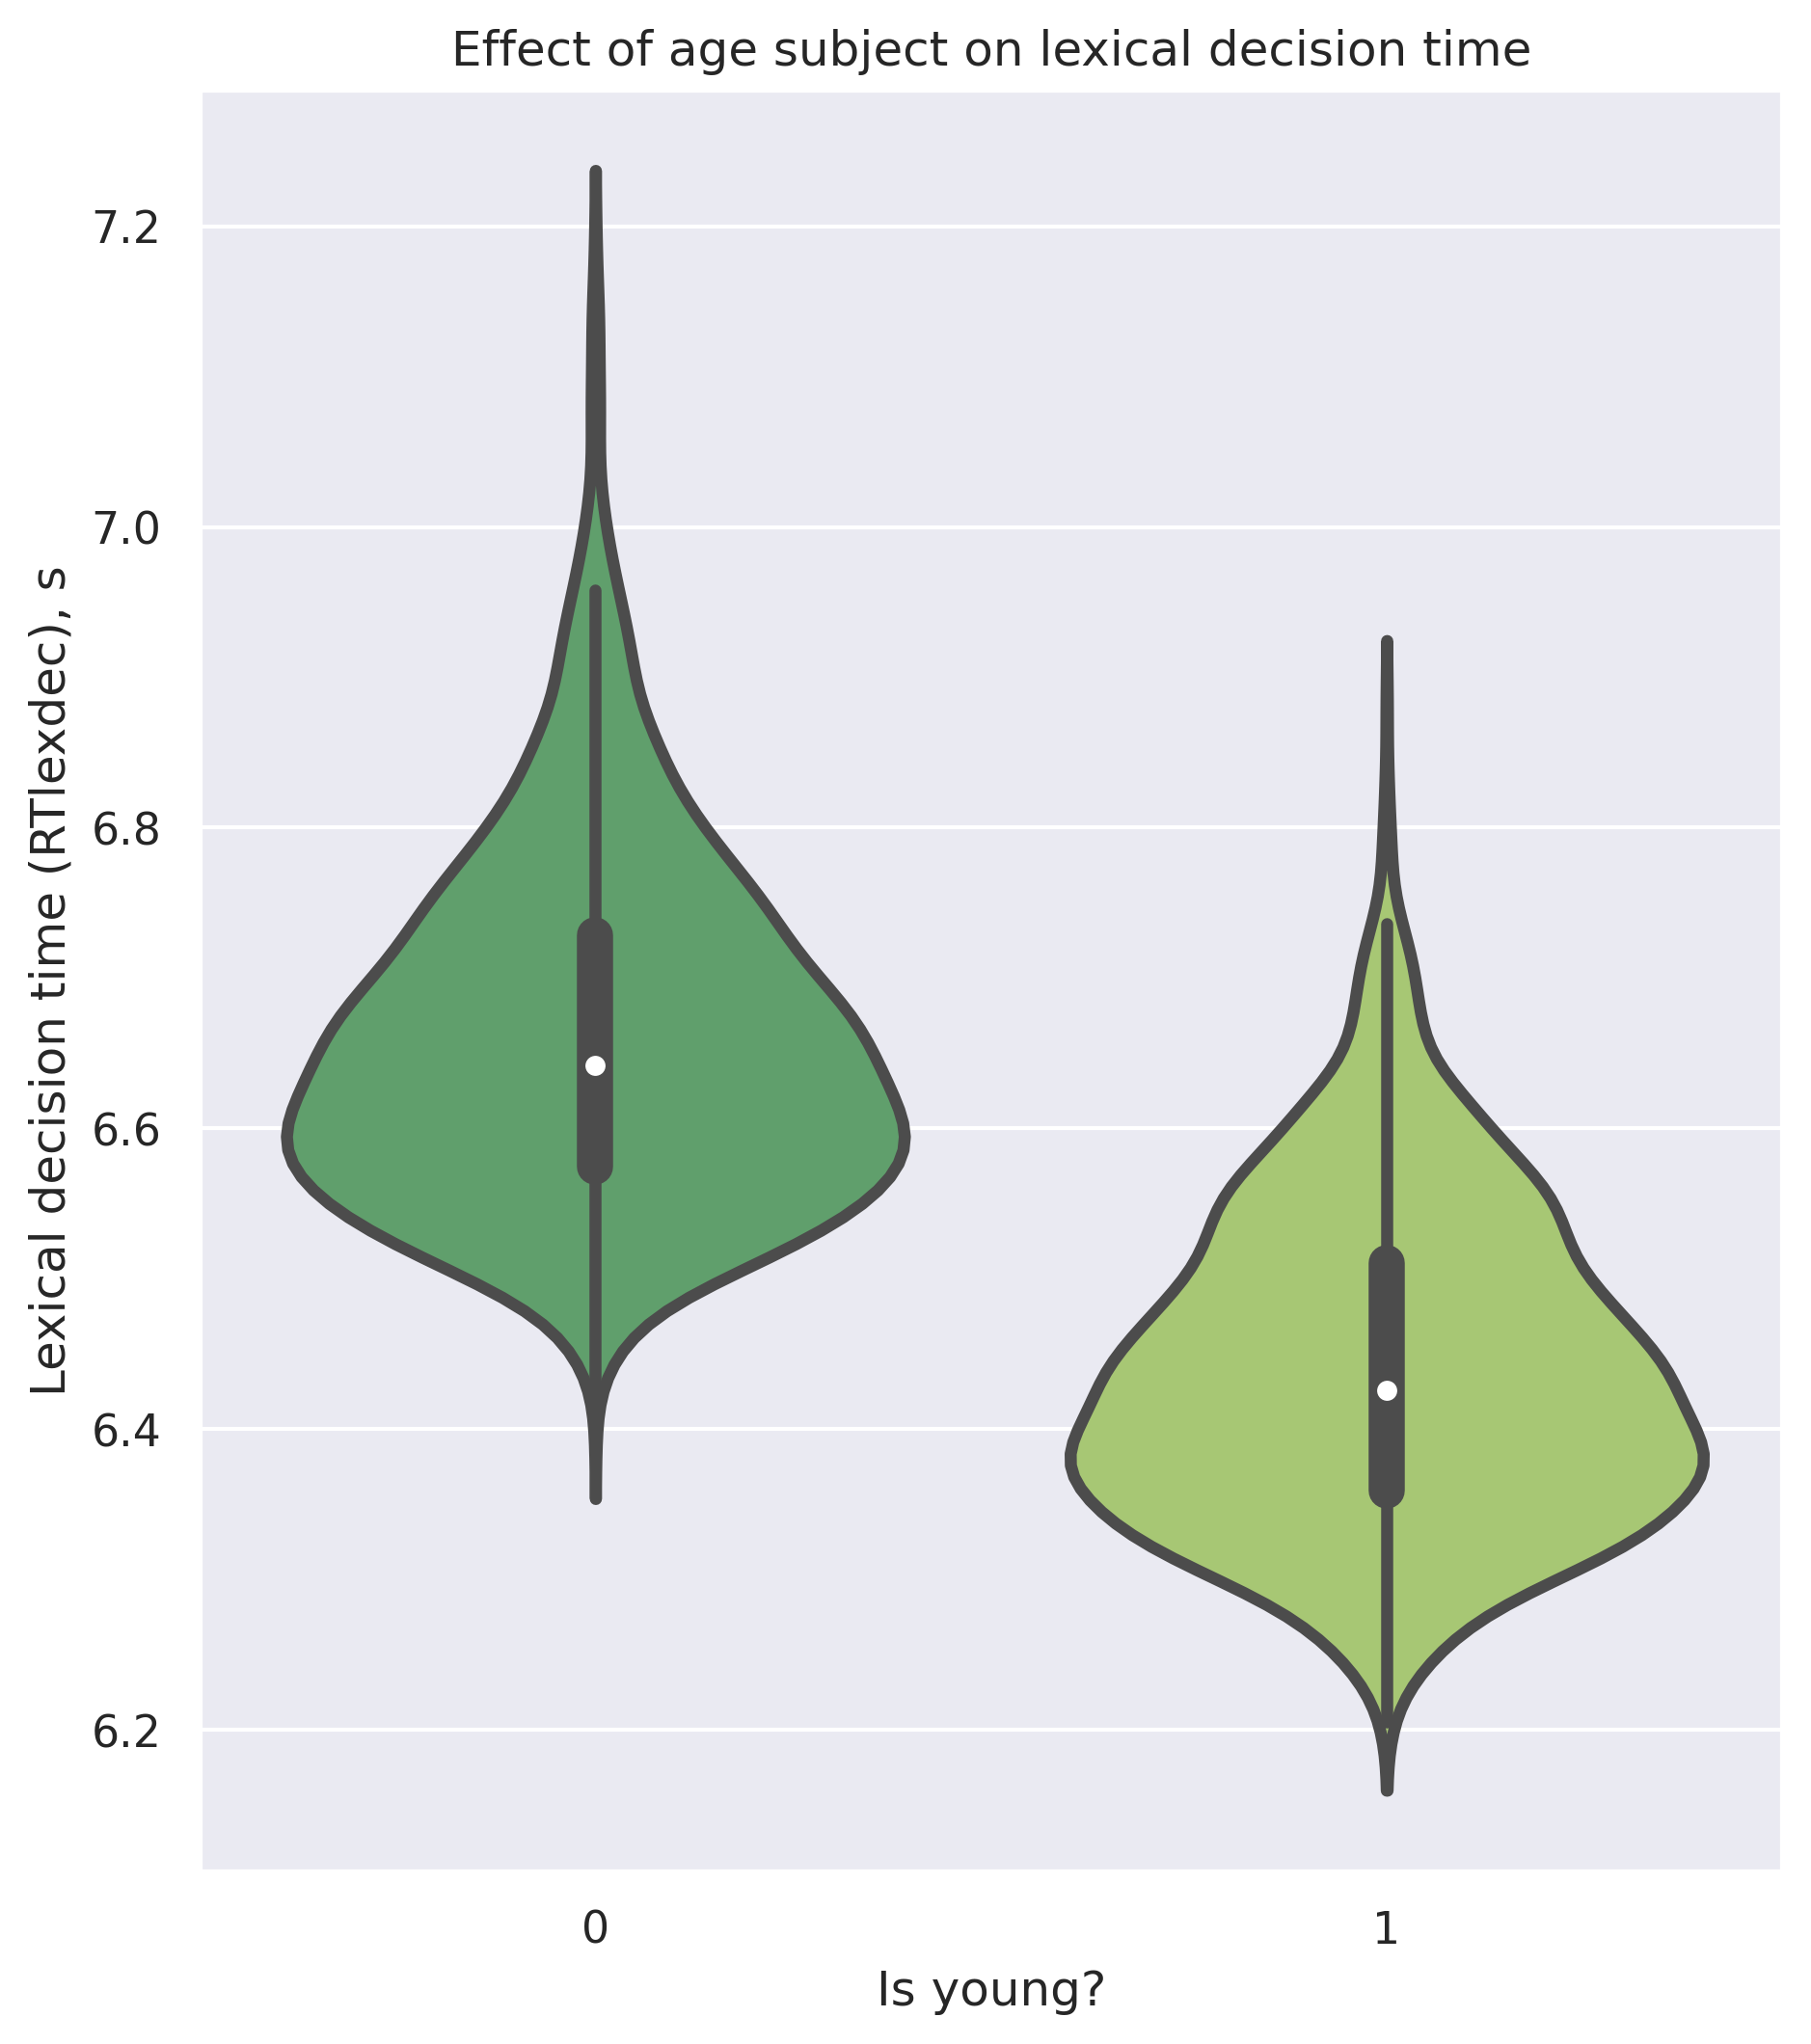

In [26]:
fig = plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
ax = sns.violinplot(data=df, x='IsYoung', y='RTlexdec', palette='summer', linewidth=3)
ax.set_title('Effect of age subject on lexical decision time')
ax.set_xlabel('Is young?')
ax.set_ylabel('Lexical decision time (RTlexdec), s')
plt.show()

Теперь исследуем вещественнозначеные признаки. Реализуем разделение по признаку **AgeSubject**.

In [27]:
rtlexdec_old = old['RTlexdec']
rtlexdec_young = young['RTlexdec']

 Признак **Familiarity**

In [28]:
familiarity_old = old['Familiarity']
familiarity_young = young['Familiarity']

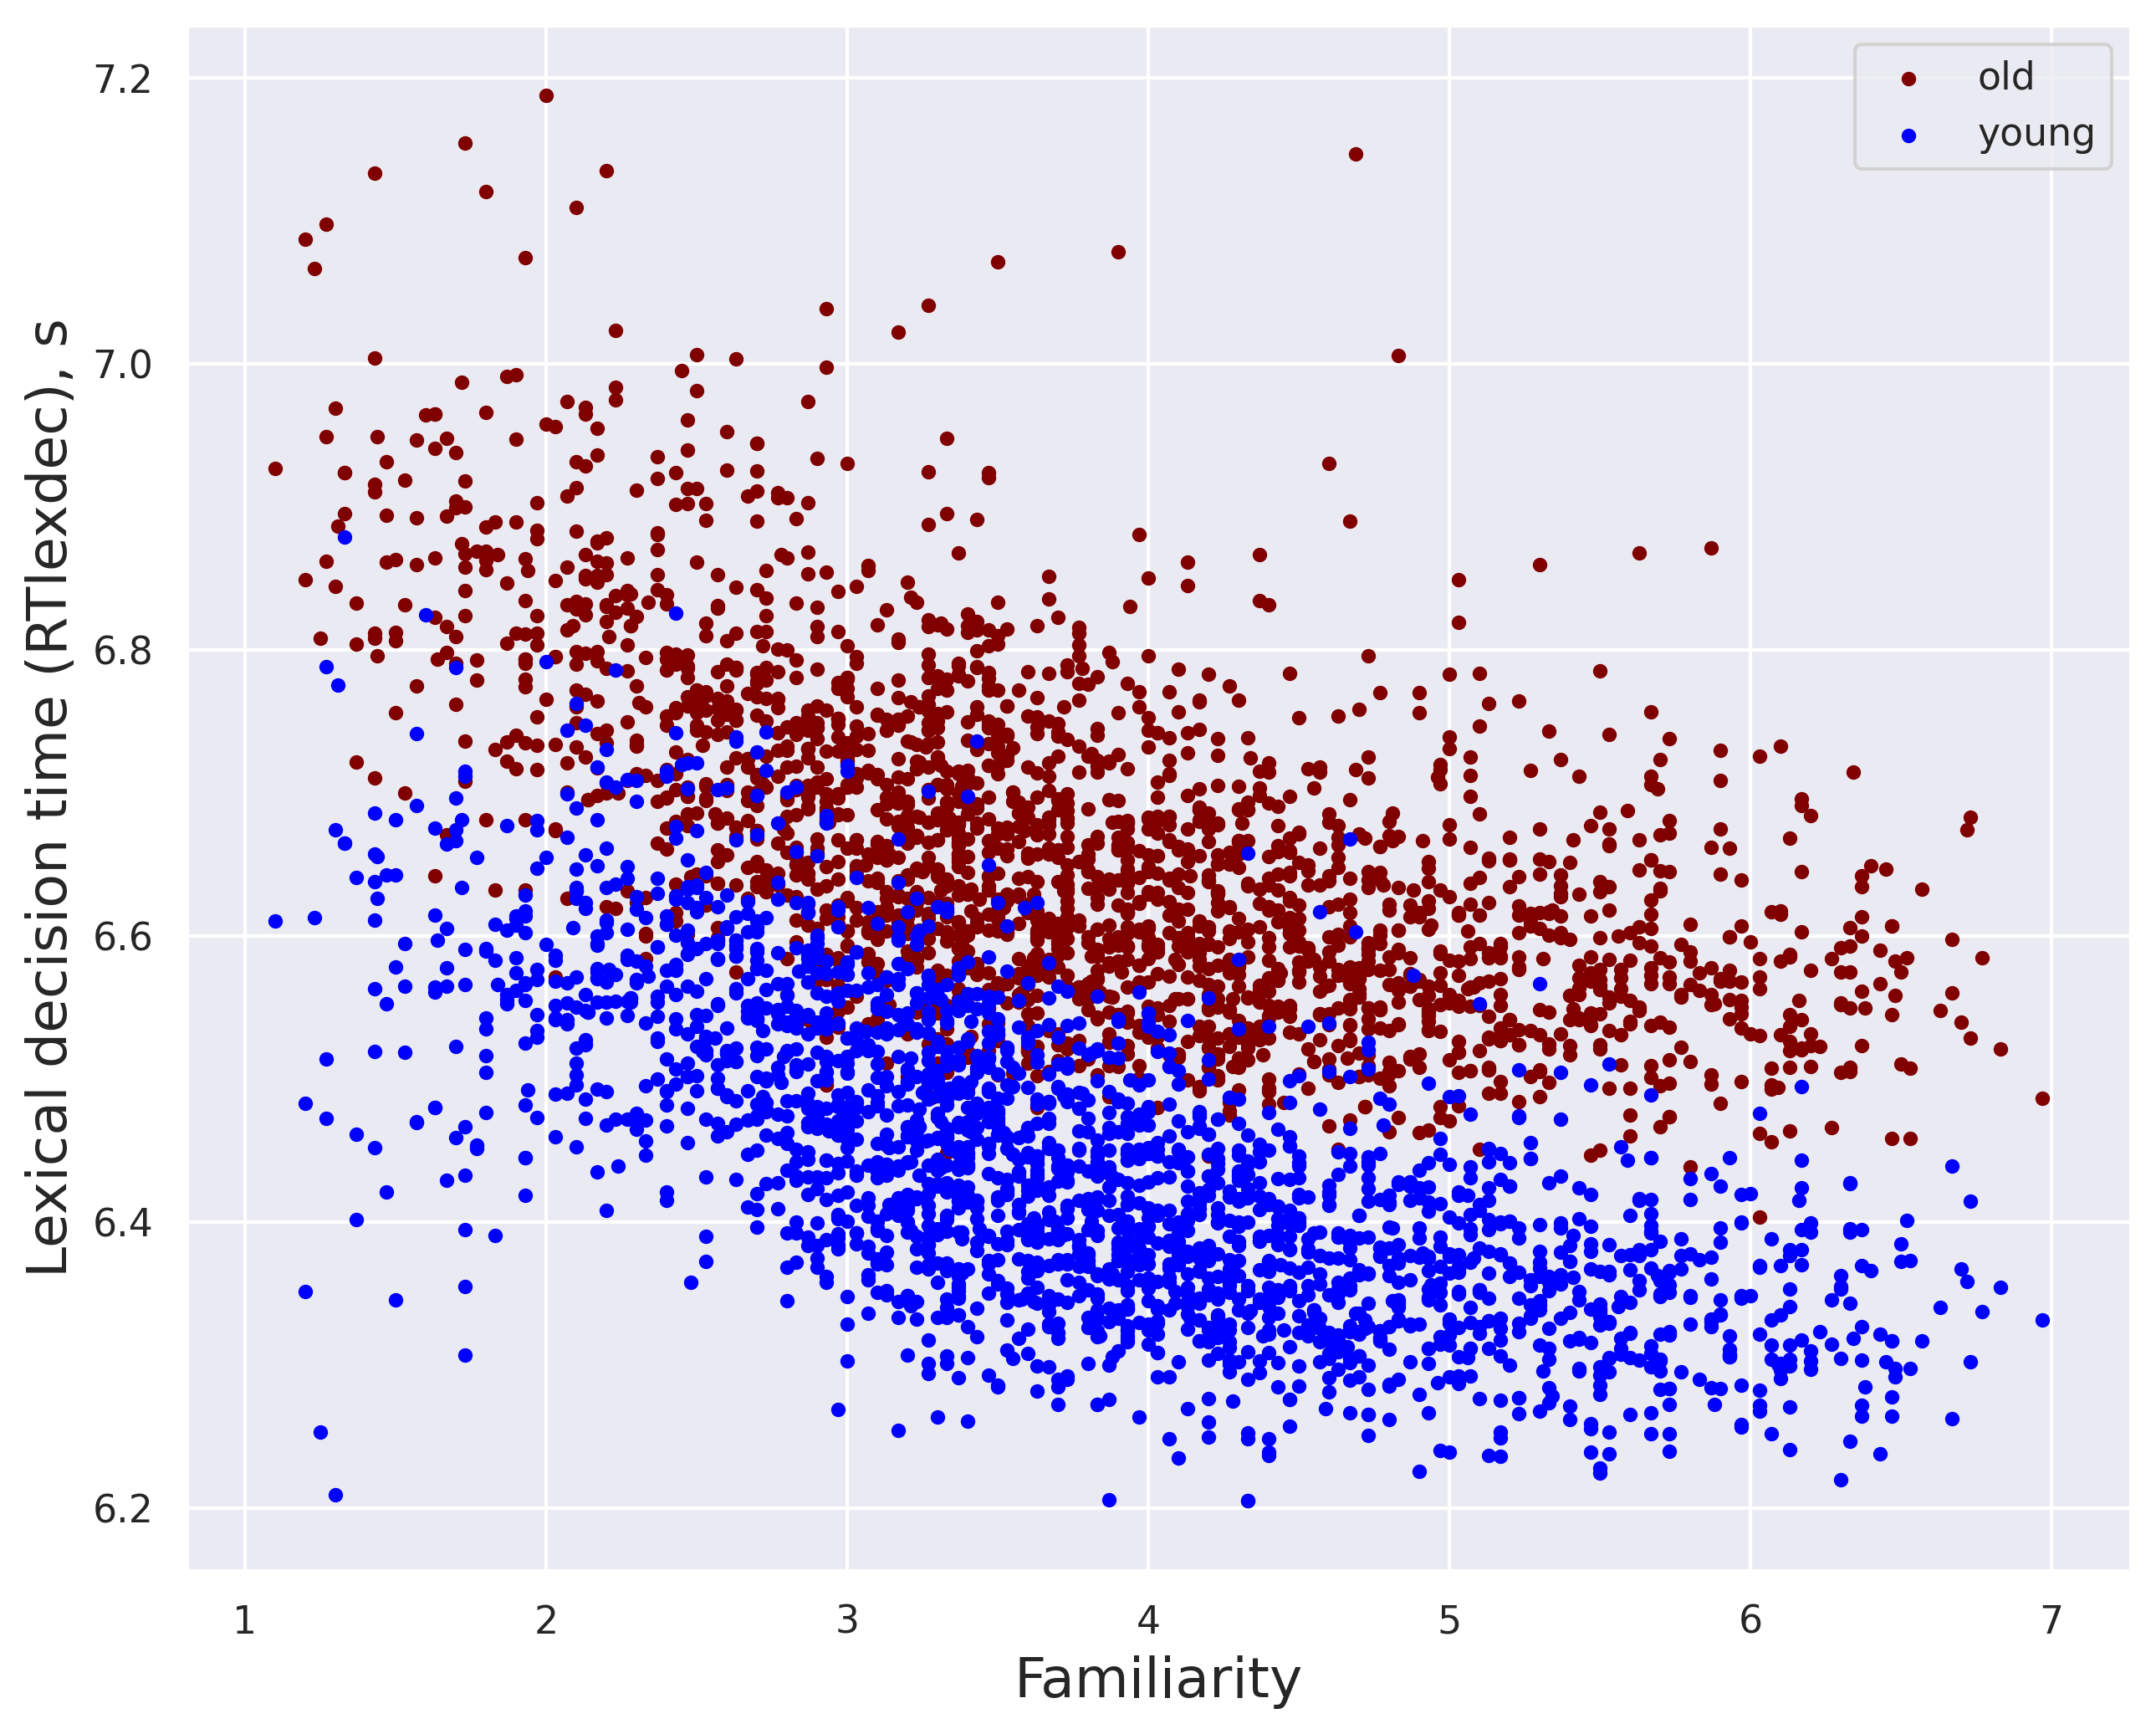

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(familiarity_old, rtlexdec_old, s=10, color='maroon', label='old')
plt.scatter(familiarity_young, rtlexdec_young, s=10, color='blue', label='young')
ax.set_xlabel('Familiarity', fontsize=16)
ax.set_ylabel('Lexical decision time (RTlexdec), s', fontsize=16)
plt.legend()
plt.show()

В целом виден тренд на уменьшение **lexical decision time** с увеличением величины **familiarity** для двух возрастных групп.

Признак **WrittenFrequency**

In [30]:
written_frequency_old = old['WrittenFrequency']
written_frequency_young = young['WrittenFrequency']

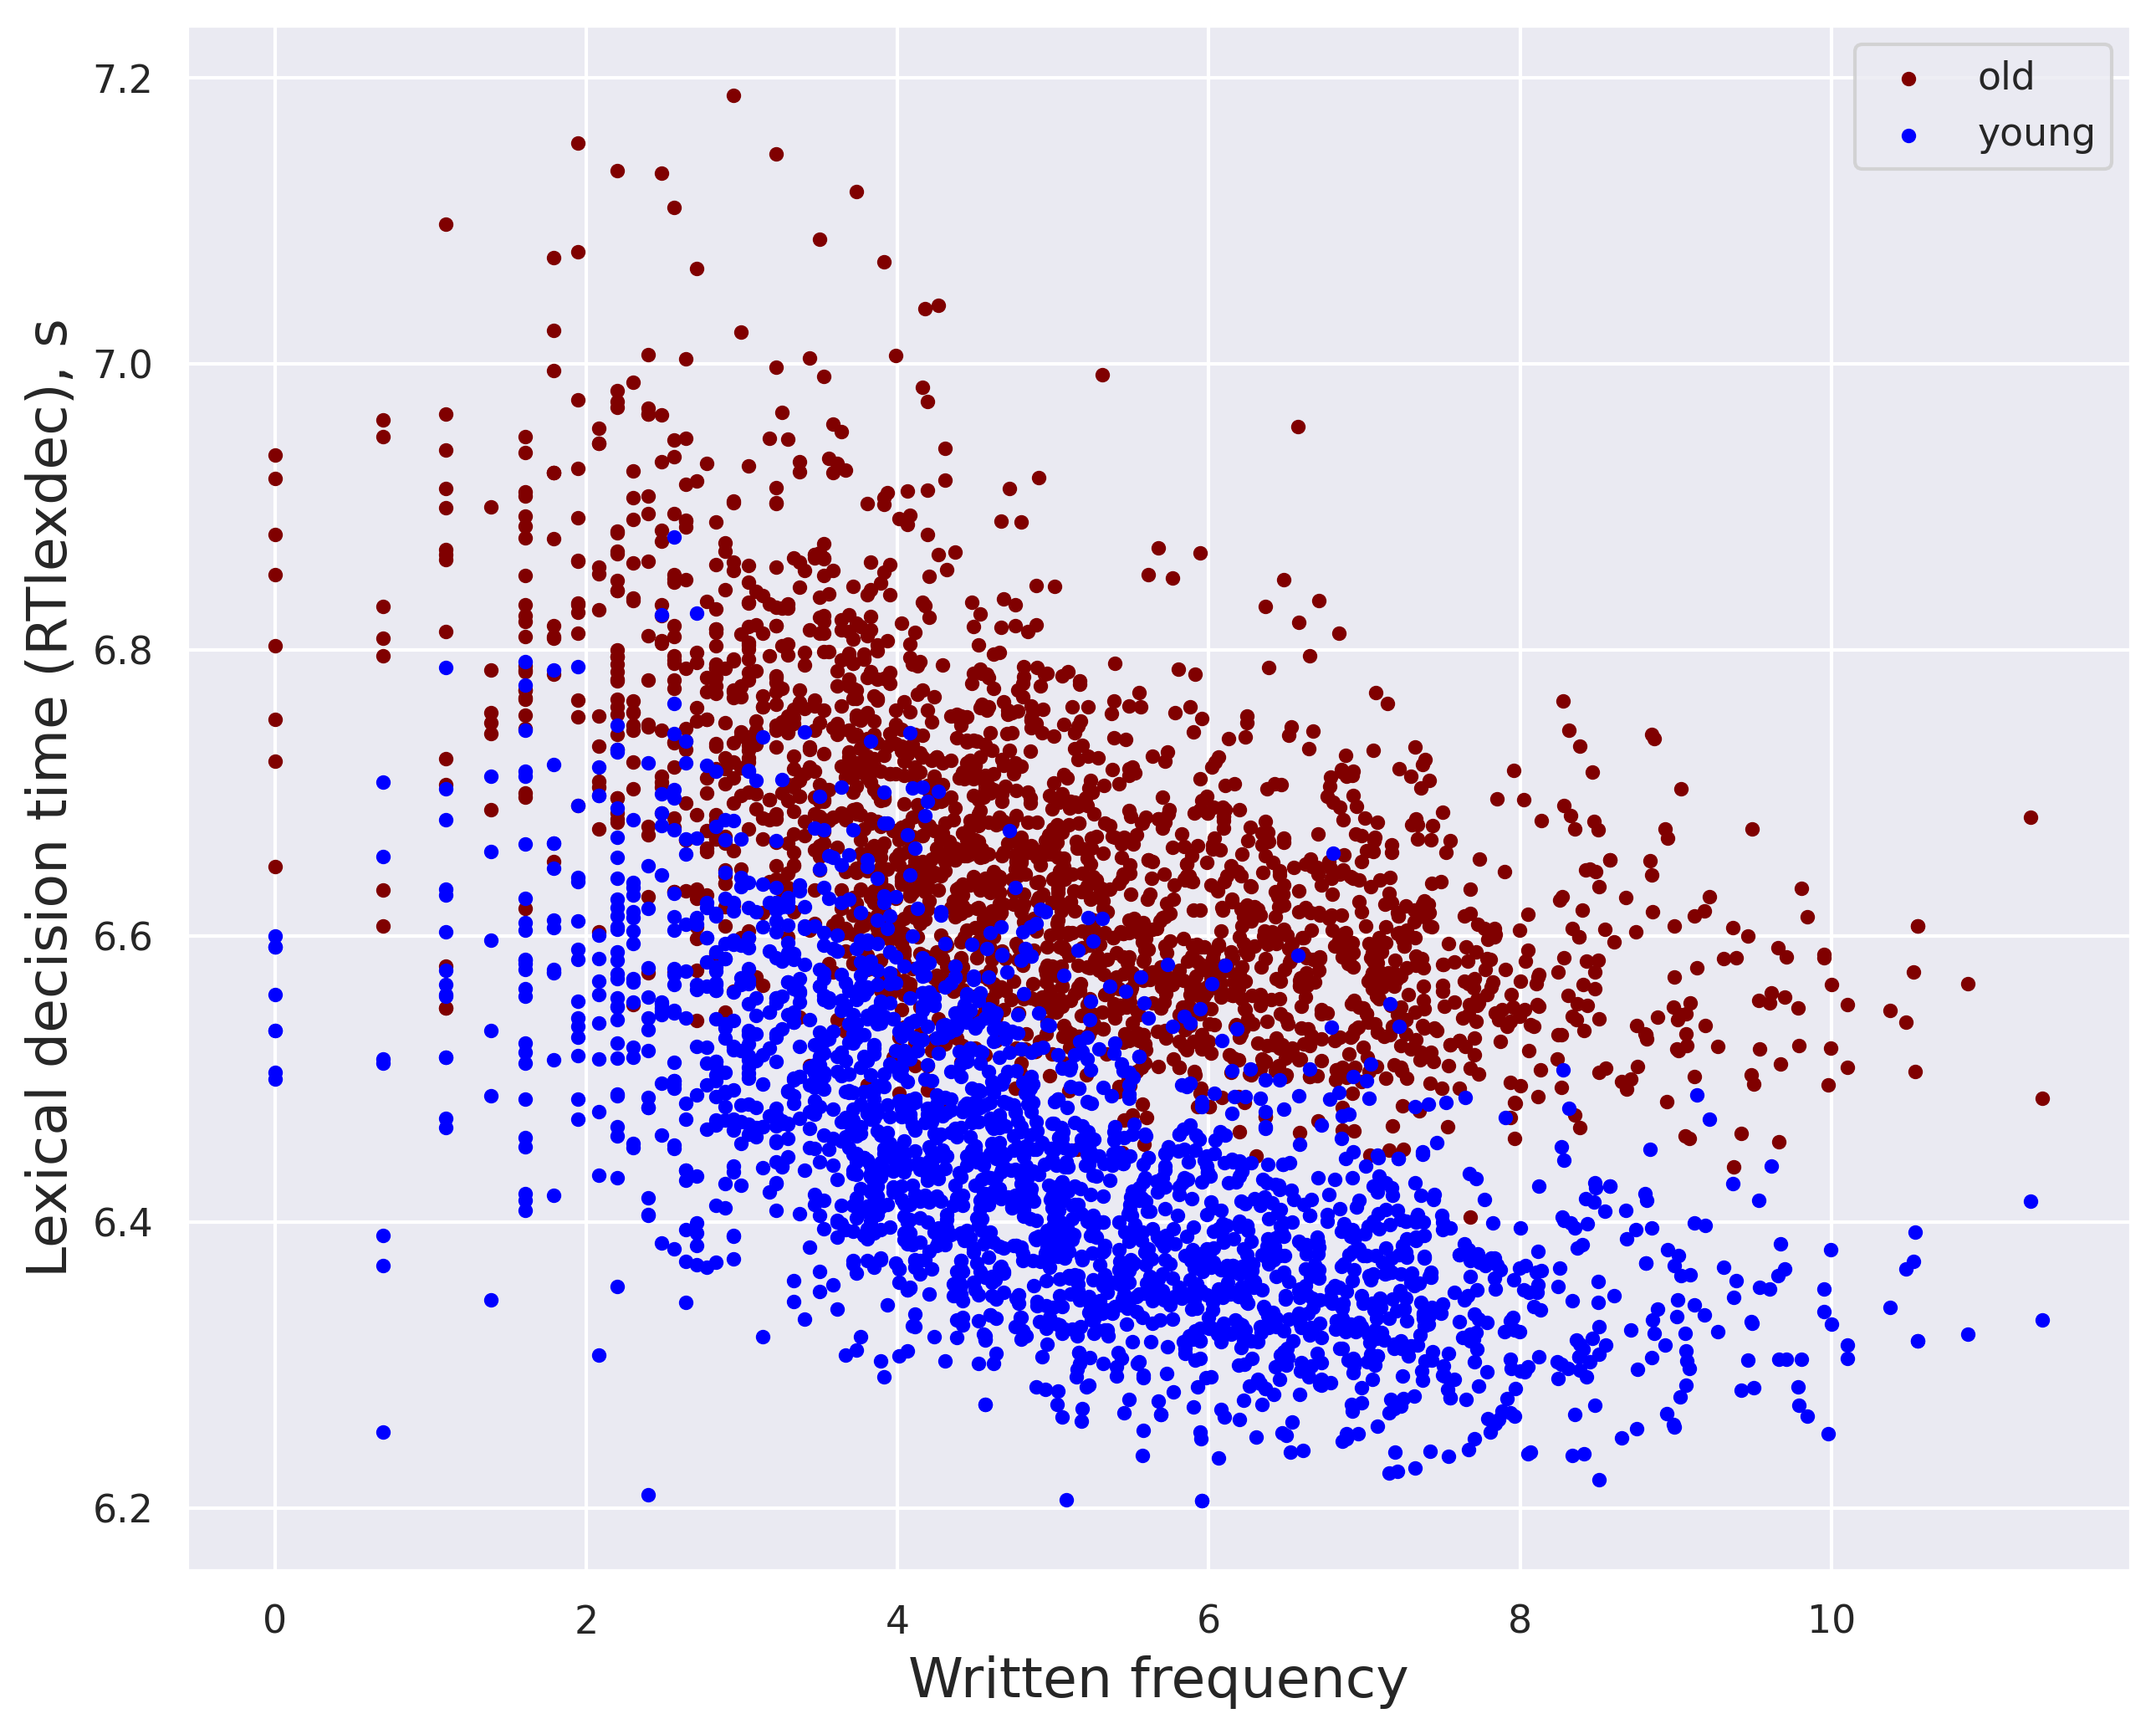

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(written_frequency_old, rtlexdec_old, s=10, color='maroon', label='old')
plt.scatter(written_frequency_young, rtlexdec_young, s=10, color='blue', label='young')
ax.set_xlabel('Written frequency', fontsize=16)
ax.set_ylabel('Lexical decision time (RTlexdec), s', fontsize=16)
plt.legend()
plt.show()

Похожая ситуация наблюдается и для признака **WrittenFrequency**.

Наконец, исследуем признак **FrequencyInitialDiphoneWord**

In [32]:
frequency_diphone_old = old['FrequencyInitialDiphoneWord']
frequency_diphone_young = young['FrequencyInitialDiphoneWord']

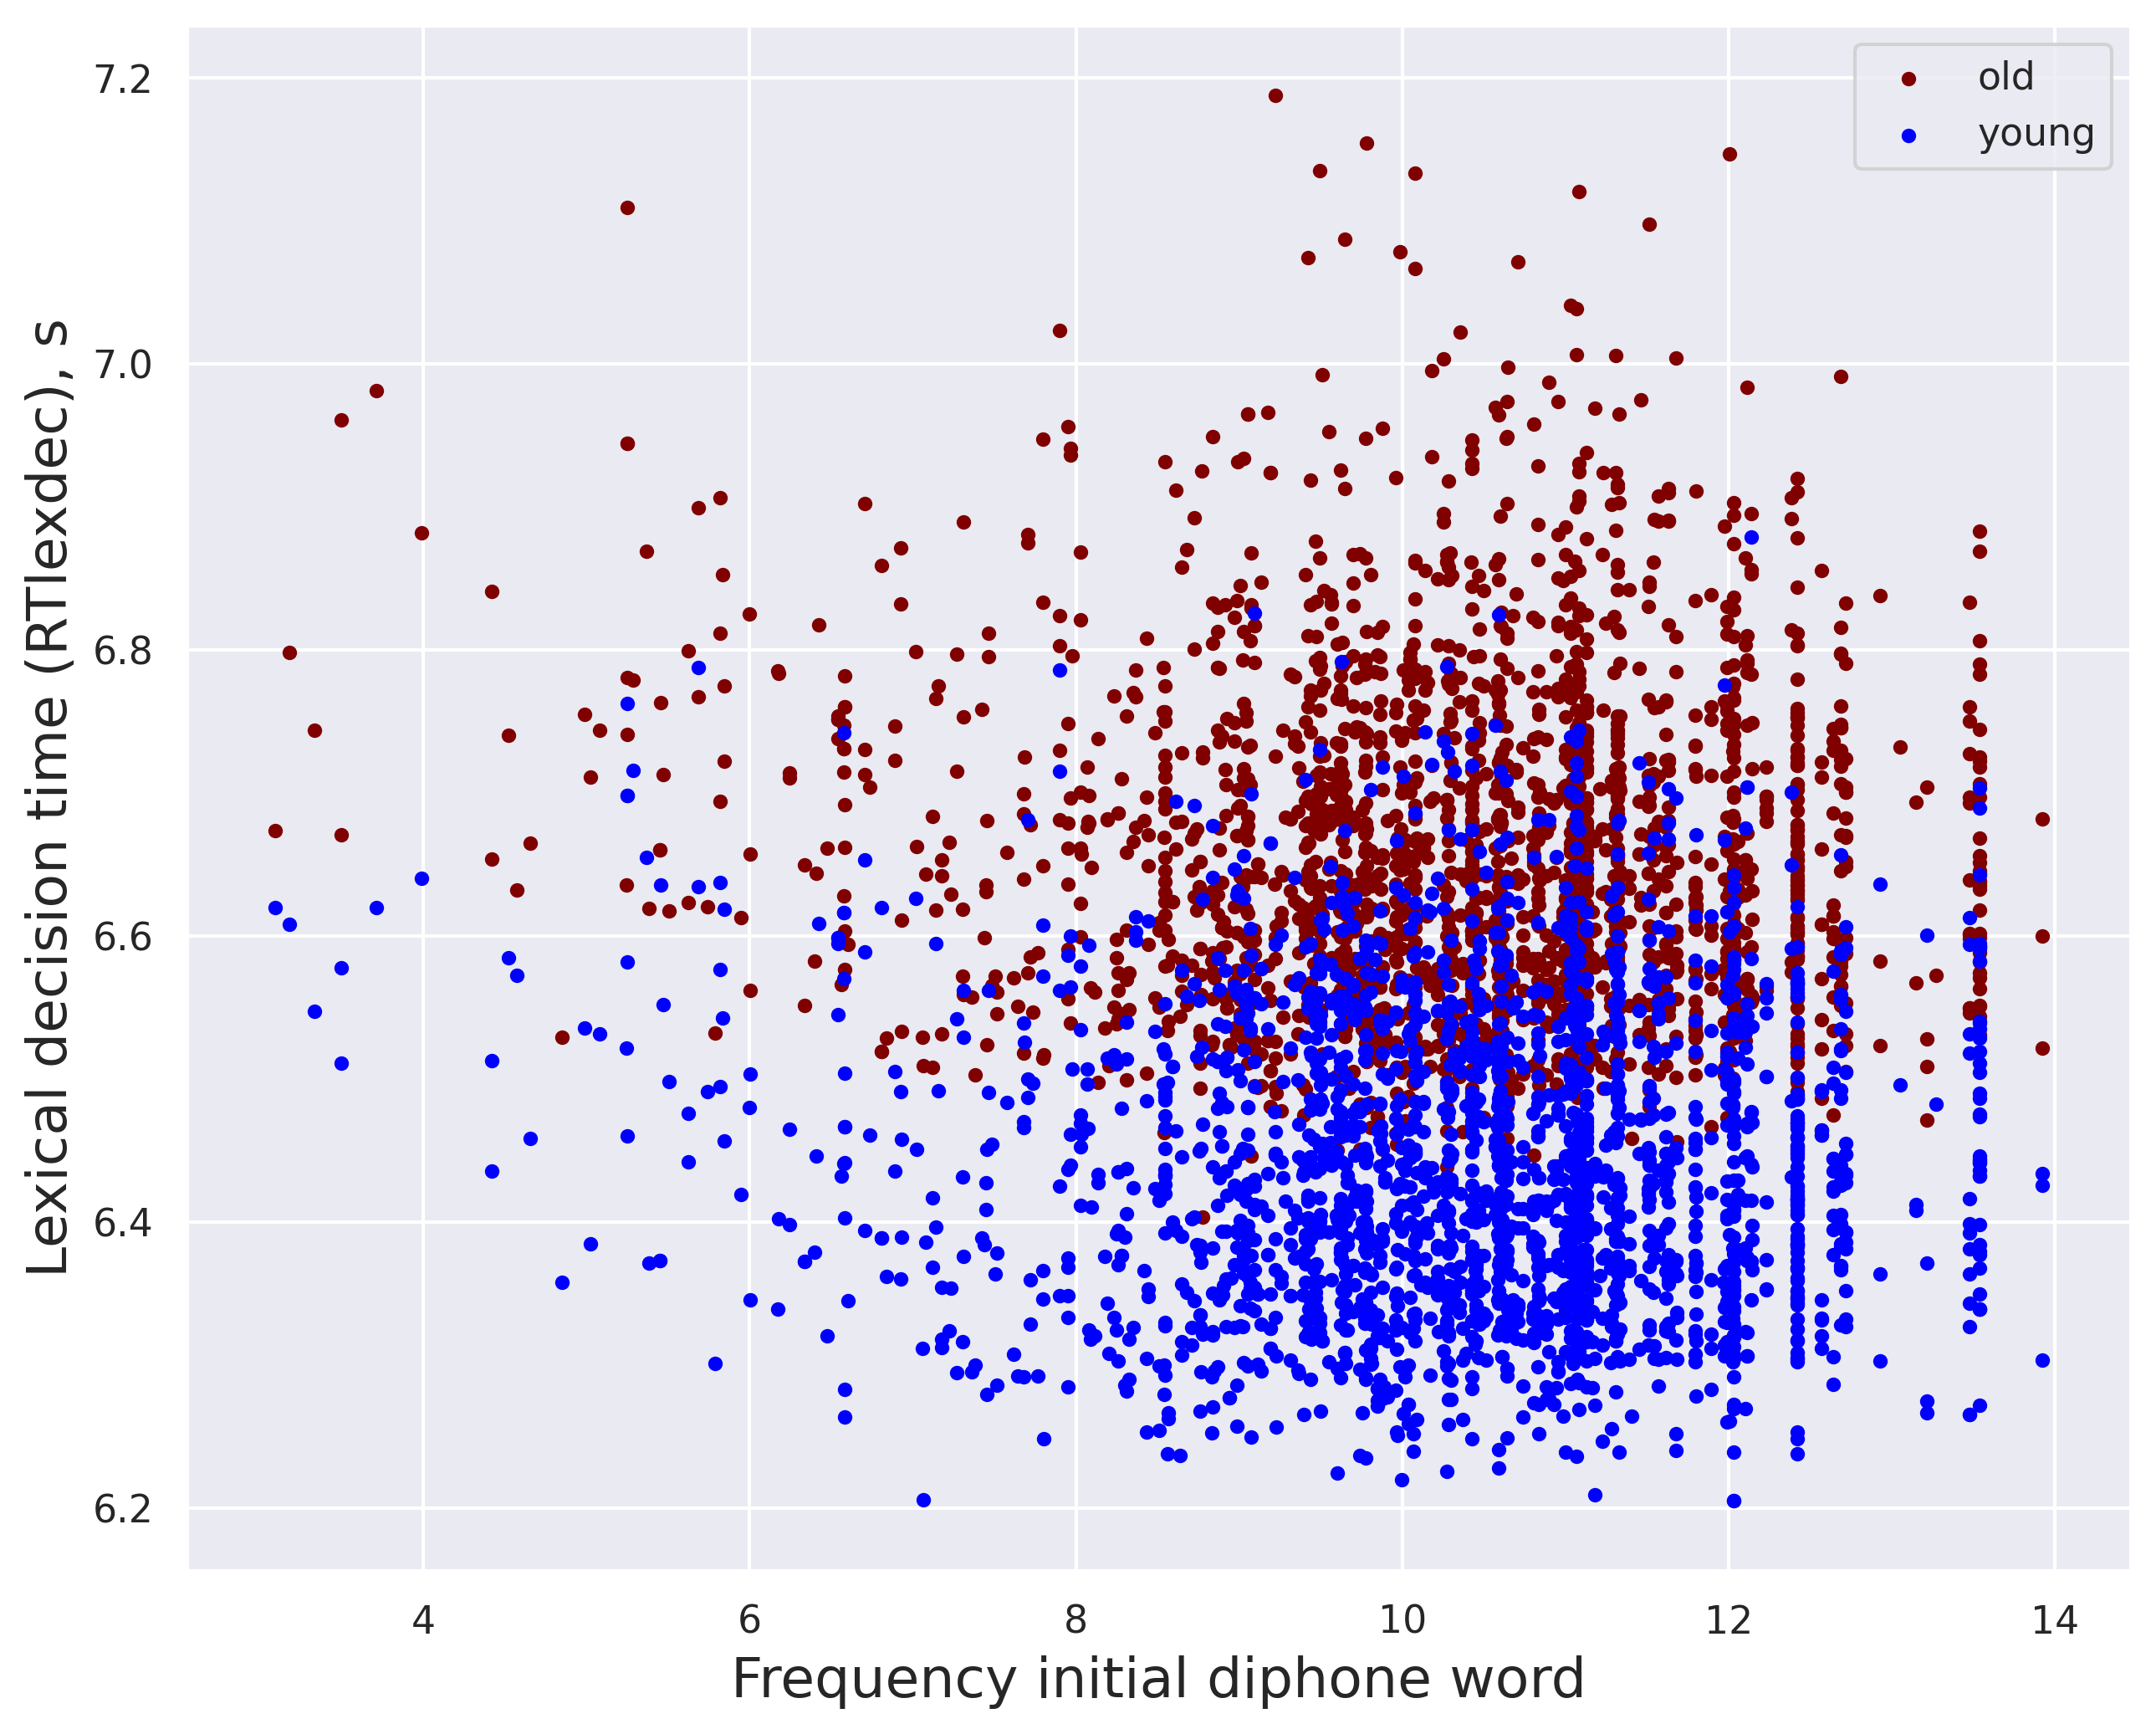

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(frequency_diphone_old, rtlexdec_old, s=10, color='maroon', label='old')
plt.scatter(frequency_diphone_young, rtlexdec_young, s=10, color='blue', label='young')
ax.set_xlabel('Frequency initial diphone word', fontsize=16)
ax.set_ylabel('Lexical decision time (RTlexdec), s', fontsize=16)
plt.legend()
plt.show()

Что-то сказать про монотонность данных довольно трудно, но разделение на две группы по возрастной категории по-прежнему наблюдается.

Осуществим перемешивание строк датасета (для того, чтобы в дальнейшем оценить качество модели на кросс-валидации)

In [34]:
df = df.sample(frac=1)

In [35]:
df.head()

RTlexdec  Familiarity  WrittenFrequency  LengthInLetters  \
4475  6.512325         4.55          6.361302                4   
1421  6.455513         4.03          4.927254                5   
926   6.457099         3.27          5.389072                4   
3077  6.516666         3.80          5.030438                3   
4482  6.566869         5.73          8.106213                4   

      FrequencyInitialDiphoneWord  IsVerb  IsYoung  
4475                     9.779341       1        0  
1421                    11.129011       0        1  
926                     10.454639       0        1  
3077                     9.444226       1        1  
4482                     9.771441       1        0

Также осуществим масштабирование данных, используя <code>sklearn.<font color='steelblue'>preprocessing</font>.StandardScaler</code>.

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [39]:
X_full = df_scaled[:, 1:]
y_full = df_scaled[:, 0]

In [40]:
X_full.shape

(4568, 6)

In [41]:
y_full.shape

(4568,)

Приступаем к обучению линейной регресии. Разобьем датасет на обучающую и тестовую выборки

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

Обучим алгоритм линейной регрессии.

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('MSE score on train set = ', mean_squared_error(pred_train, y_train))
print('MSE score on test set = ', mean_squared_error(pred_test, y_test))
print('R2 score on train set = ', lr.score(X_train, y_train))
print('R2 score on test set = ', lr.score(X_test, y_test))

MSE score on train set =  0.28639504291099
MSE score on test set =  0.2785510965857789
R2 score on train set =  0.7161996122518958
R2 score on test set =  0.7107613531342221


Получили приемлемые результаты для линейной регрессии без регуляризации. Выпишем значения весов

In [45]:
columns_list = list(df.columns[1:])

print(f"{'Feature' : <30}{'Weight' : <20}")
for i in range(len(columns_list)):
    if lr.coef_[i] < 0:
        print(f"{columns_list[i] : <30}{lr.coef_[i]}")
    else:
        print(f"{columns_list[i] : <30}{' '}{lr.coef_[i]}")

Feature                       Weight              
Familiarity                   -0.2767720288183019
WrittenFrequency              -0.22459715097493924
LengthInLetters                0.015101908181490804
FrequencyInitialDiphoneWord    0.012128165936829591
IsVerb                        -0.010646551135006312
IsYoung                       -0.707869064983647


Видим, что признак **FrequencyInitialDiphoneWord** имеет очень малый вес.

Попрубуем улучшить регрессионную модель, применив отбор признаков и регуляризацию. Сначала уберем из рассмотрения признак **FrequencyInitialDiphoneWord**.

In [46]:
X_significant = np.delete(X_full, 3, axis=1)

In [47]:
X_significant.shape

(4568, 5)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X_significant, y_full, test_size=0.2, random_state=42
)

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [50]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('MSE score on train set = ', mean_squared_error(pred_train, y_train))
print('MSE score on test set = ', mean_squared_error(pred_test, y_test))
print('R2 score on train set = ', lr.score(X_train, y_train))
print('R2 score on test set = ', lr.score(X_test, y_test))

MSE score on train set =  0.28653715239641886
MSE score on test set =  0.27775126982521803
R2 score on train set =  0.7160587902367608
R2 score on test set =  0.7115918679402568


Качество модели почти не изменилось.

Попробуем применить регуляризацию. Построим зависимость качества модели <code>r2_score</code> на полной выборке от величины параметра регуляризации

In [51]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [52]:
alpha_list = np.concatenate((
    np.linspace(0.0, 0.9, 10),
    np.linspace(1.0, 9.0, 9),
    np.linspace(10.0, 90.0, 9),
    np.linspace(100.0, 900.0, 9),
    np.linspace(1000.0, 9000.0, 9)))

score_ridge_list = []
for alpha in alpha_list:
    lr_ridge = Ridge(alpha=alpha).fit(X_significant, y_full)
    score_ridge = lr_ridge.score(X_significant, y_full)
    score_ridge_list.append(score_ridge)

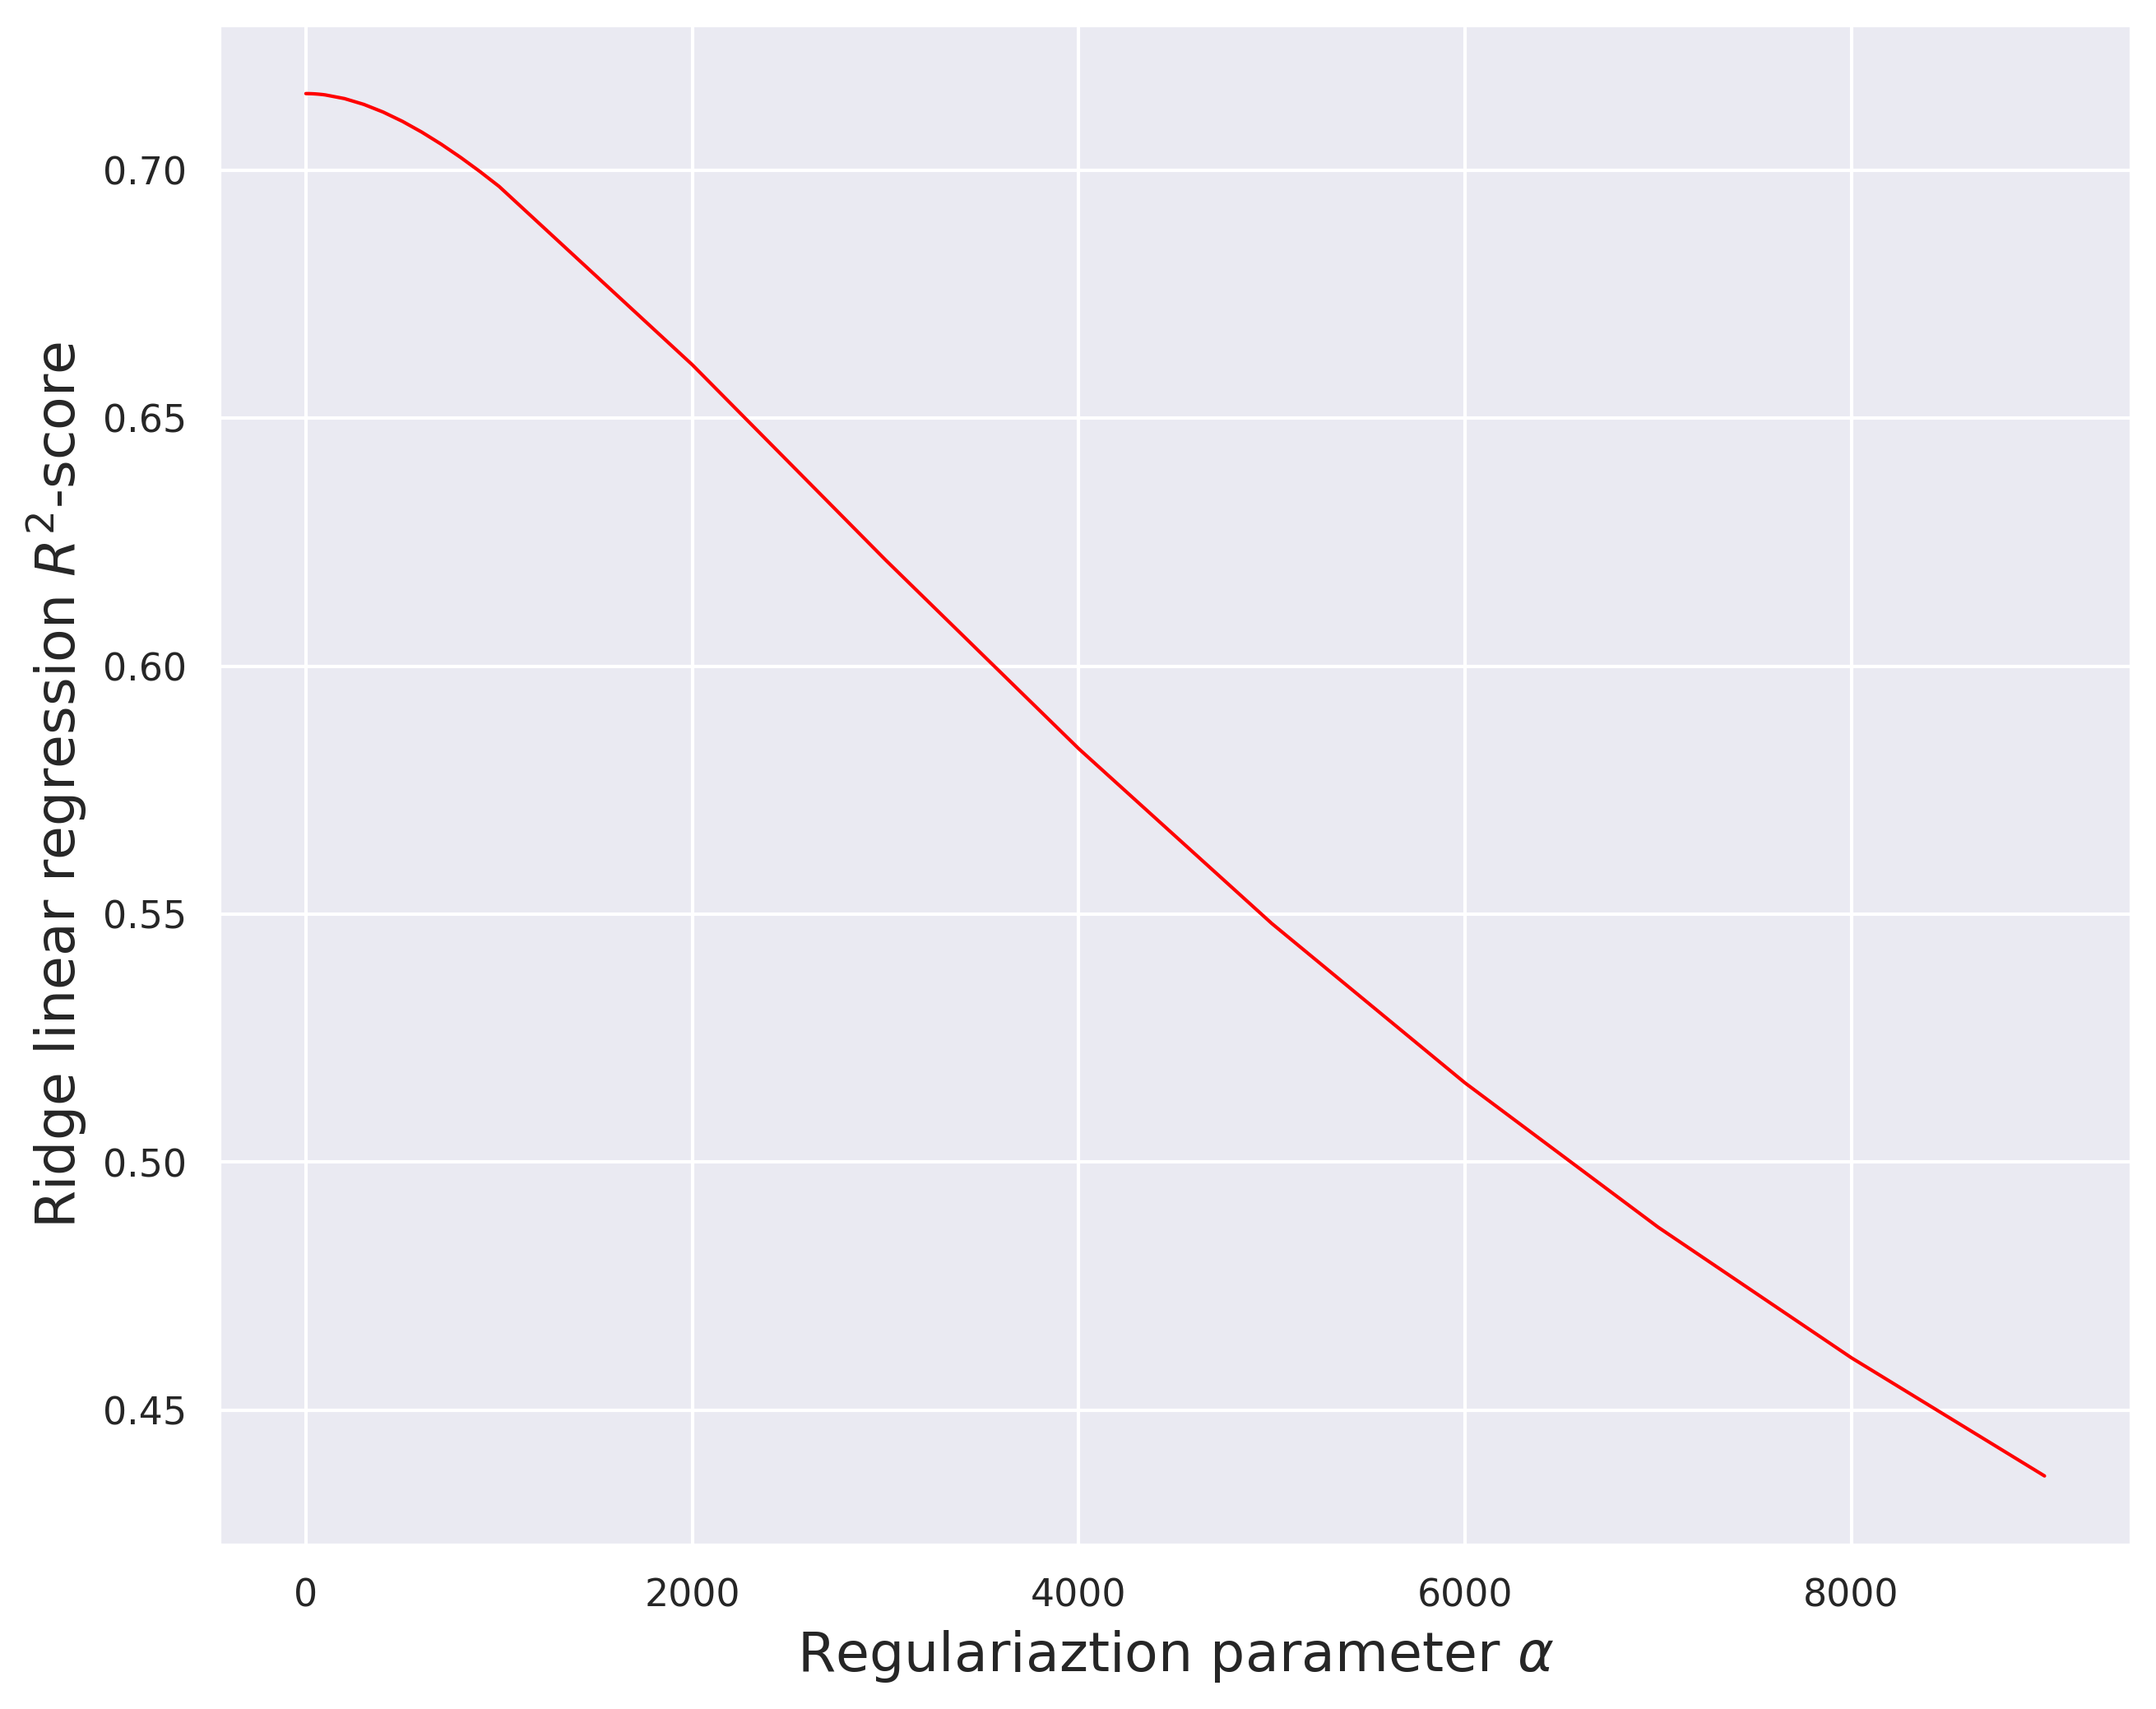

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(alpha_list, score_ridge_list, lw=1.0, color='red')
ax.set_xlabel(r'Regulariaztion parameter $\alpha$', fontsize=16)
ax.set_ylabel(r'Ridge linear regression $R^2$-score', fontsize=16)
plt.show()

Видно, что с ростом параметра регуляризации для **Ridge-регуляризации** коэффициент детерминации уменьшается.

In [54]:
alpha_list = np.linspace(0.0, 0.99, 100)

score_lasso_list = []
for alpha in alpha_list:
    ls_lasso = Lasso(alpha=alpha).fit(X_significant, y_full)
    score_lasso = ls_lasso.score(X_significant, y_full)
    score_lasso_list.append(score_lasso)

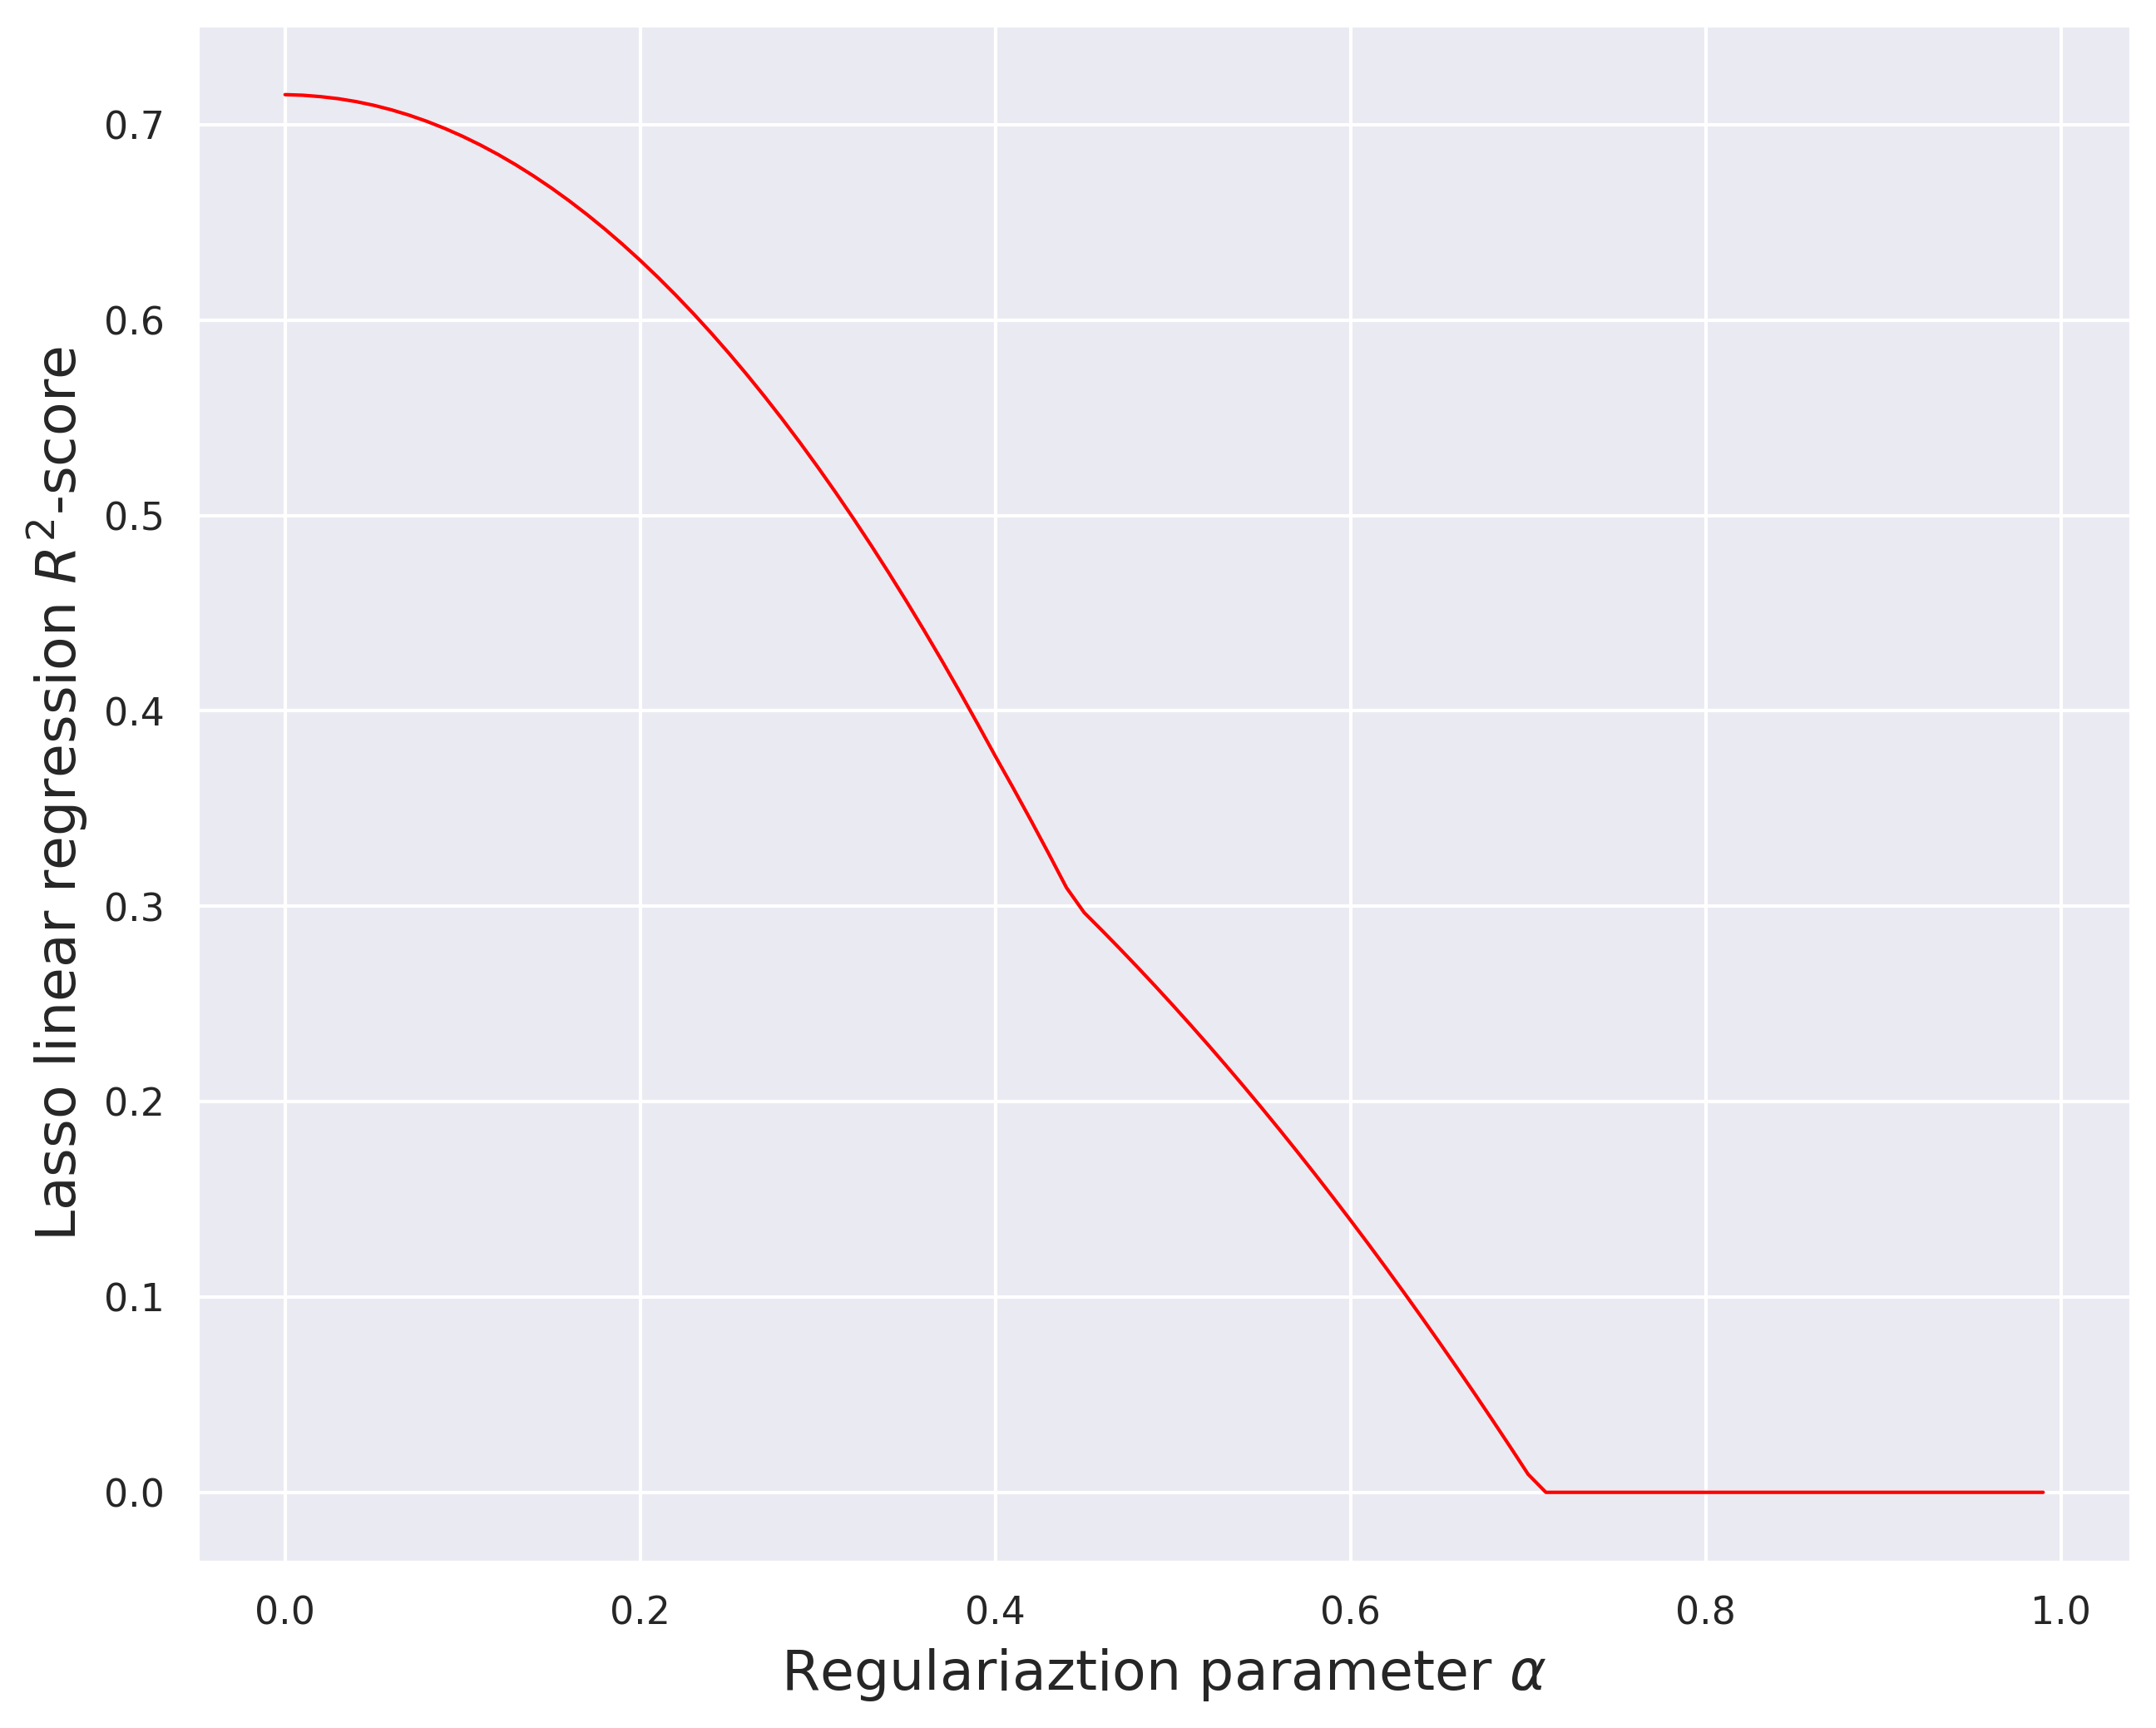

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(alpha_list, score_lasso_list, lw=1.0, color='red')
ax.set_xlabel(r'Regulariaztion parameter $\alpha$', fontsize=16)
ax.set_ylabel(r'Lasso linear regression $R^2$-score', fontsize=16)
plt.show()

In [56]:
alpha_list = np.linspace(0.0, 0.99, 100)

score_elastic_list = []
for alpha in alpha_list:
    ls_elastic = ElasticNet(alpha=alpha).fit(X_significant, y_full)
    score_elastic = ls_elastic.score(X_significant, y_full)
    score_elastic_list.append(score_elastic)

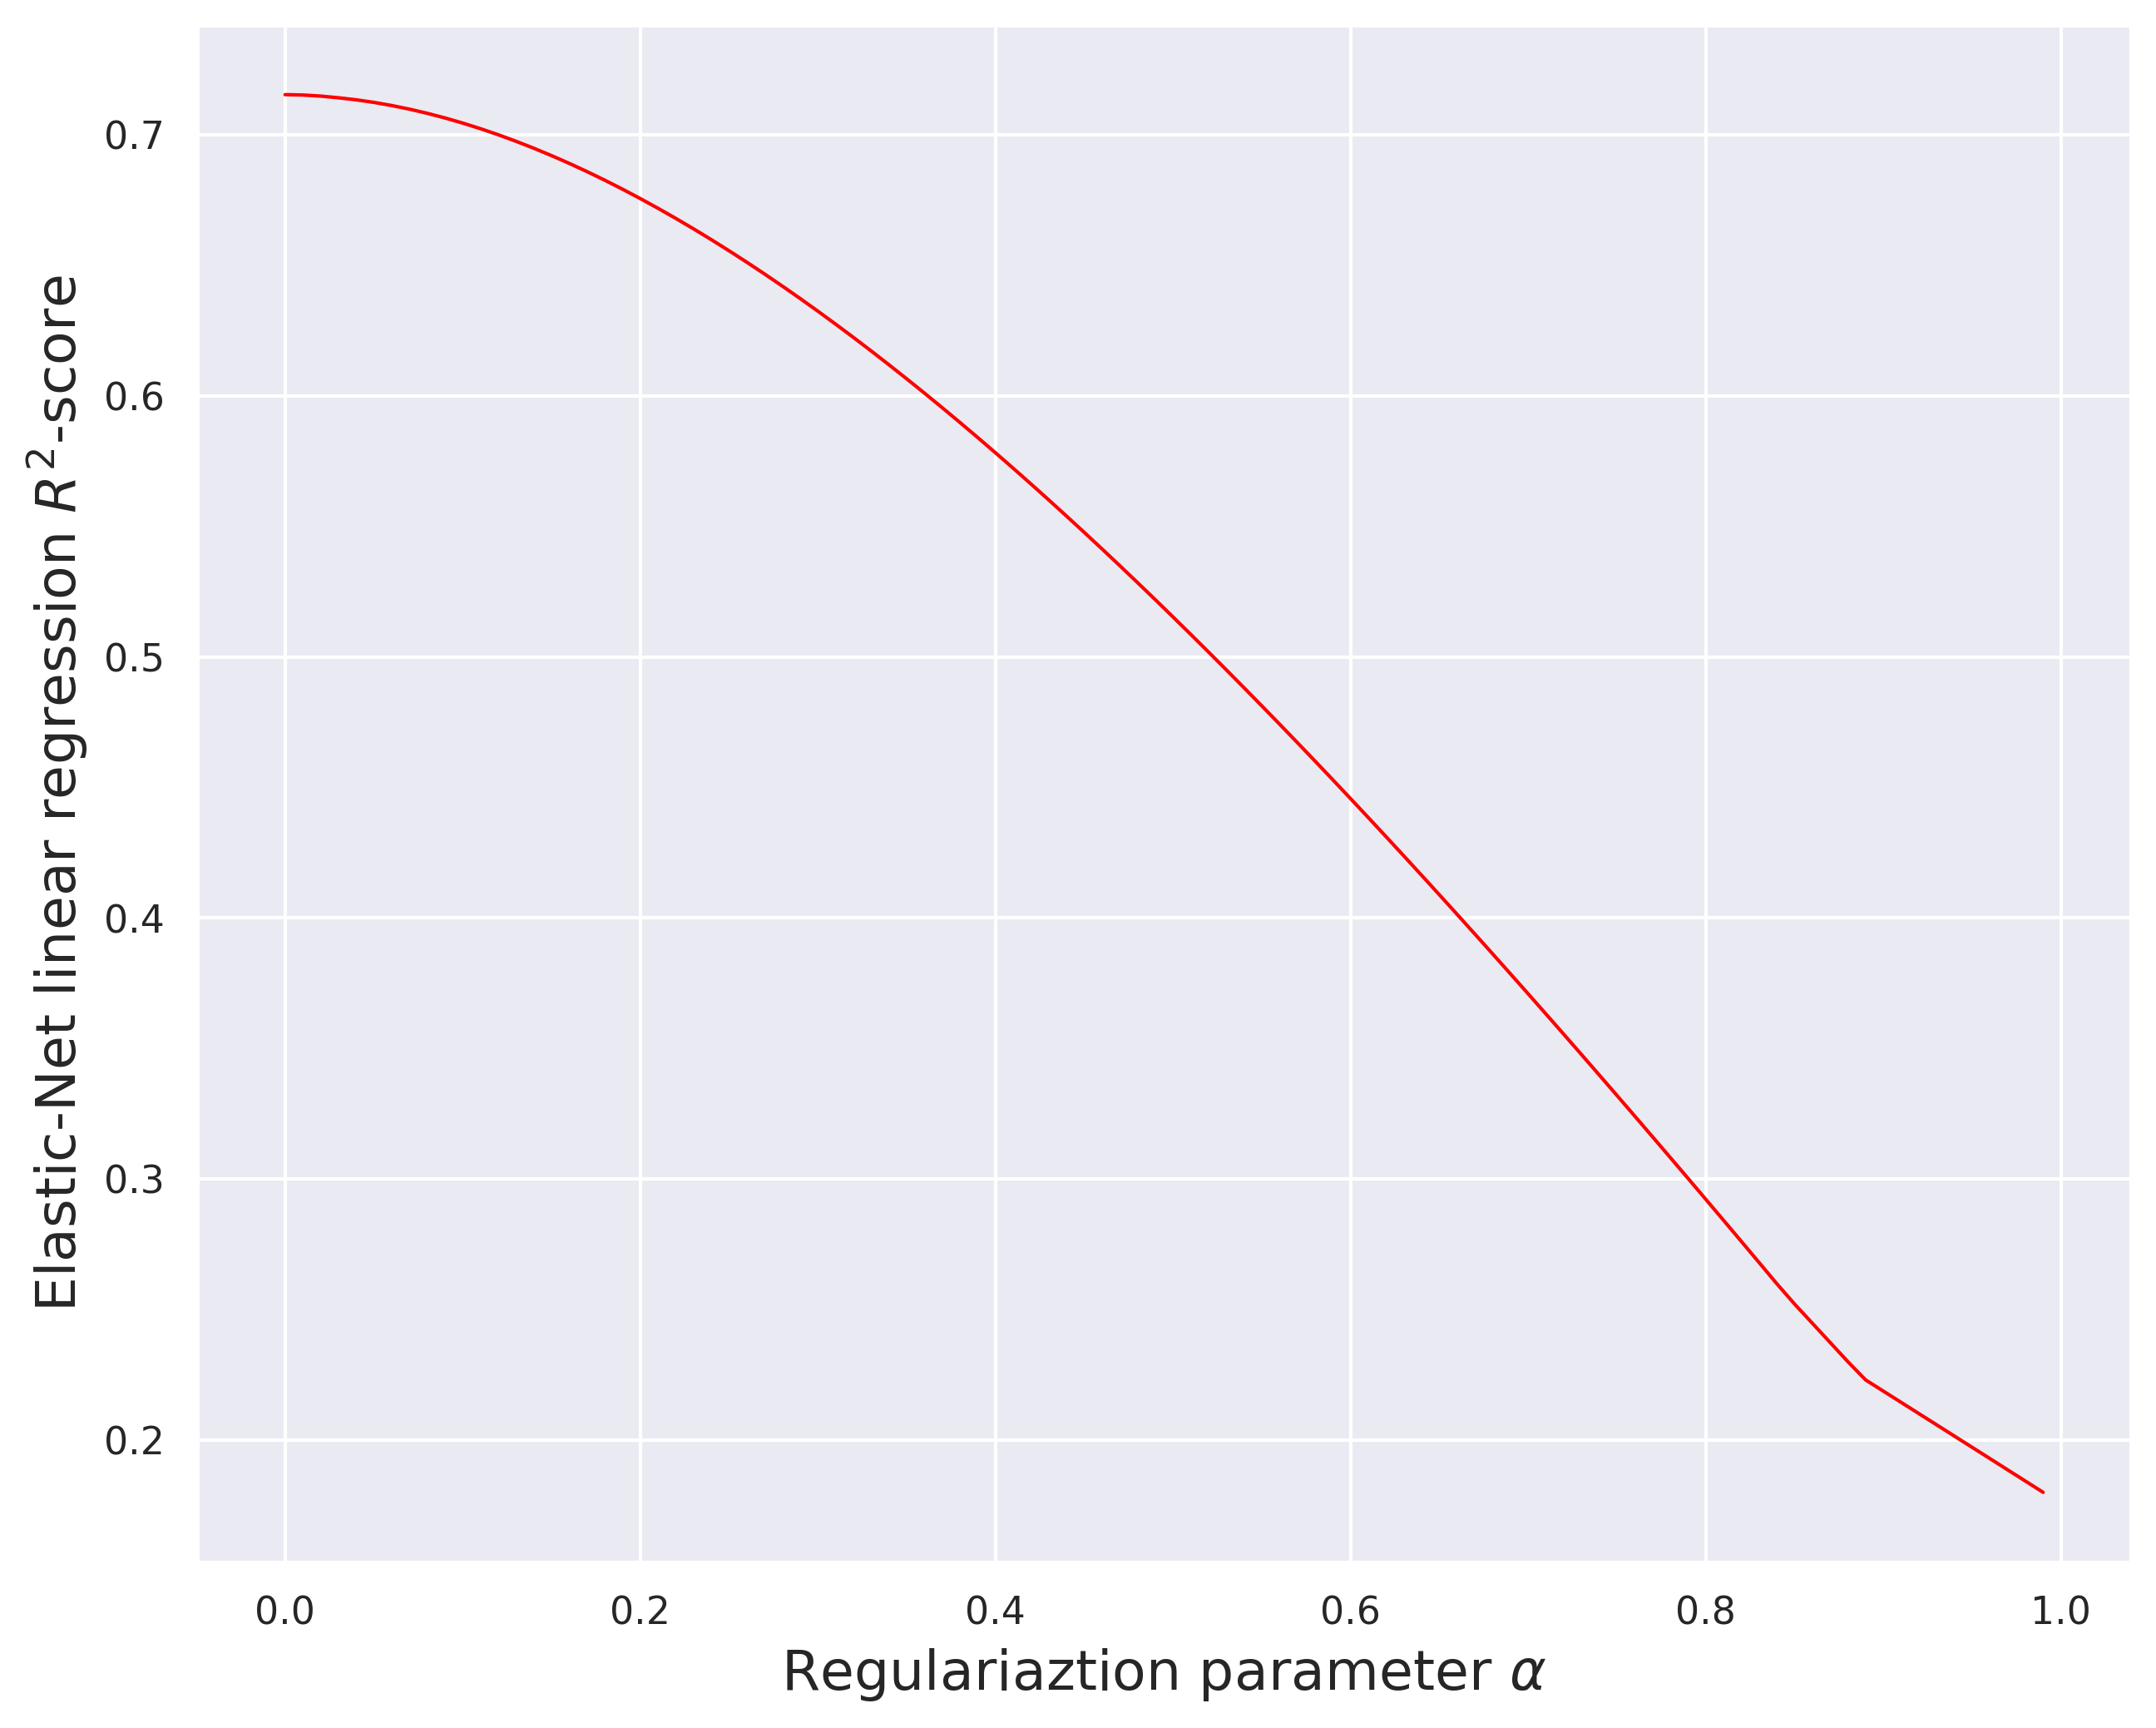

In [57]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(alpha_list, score_elastic_list, lw=1.0, color='red')
ax.set_xlabel(r'Regulariaztion parameter $\alpha$', fontsize=16)
ax.set_ylabel(r'Elastic-Net linear regression $R^2$-score', fontsize=16)
plt.show()

Для **Lasso-** и **Elastic-Net-регуляризации** коэффициент детерминации также уменьшается с ростом параметра регуляризации.

Оставим признаки с самыми наибольшими весами: **Familiarity**, **WrittenFrequency** и **IsYoung**

In [58]:
X_significant = np.delete(X_full, [2, 3, 4], axis=1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_significant, y_full, test_size=0.2, random_state=42
)

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [61]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('MSE score on train set = ', mean_squared_error(pred_train, y_train))
print('MSE score on test set = ', mean_squared_error(pred_test, y_test))
print('R2 score on train set = ', lr.score(X_train, y_train))
print('R2 score on test set = ', lr.score(X_test, y_test))

MSE score on train set =  0.2869003835752525
MSE score on test set =  0.2769452537513807
R2 score on train set =  0.7156988498259653
R2 score on test set =  0.7124288095334017


Качество модели тоже почти не изменилось.

Посмотрим на корреляцию между признаками.

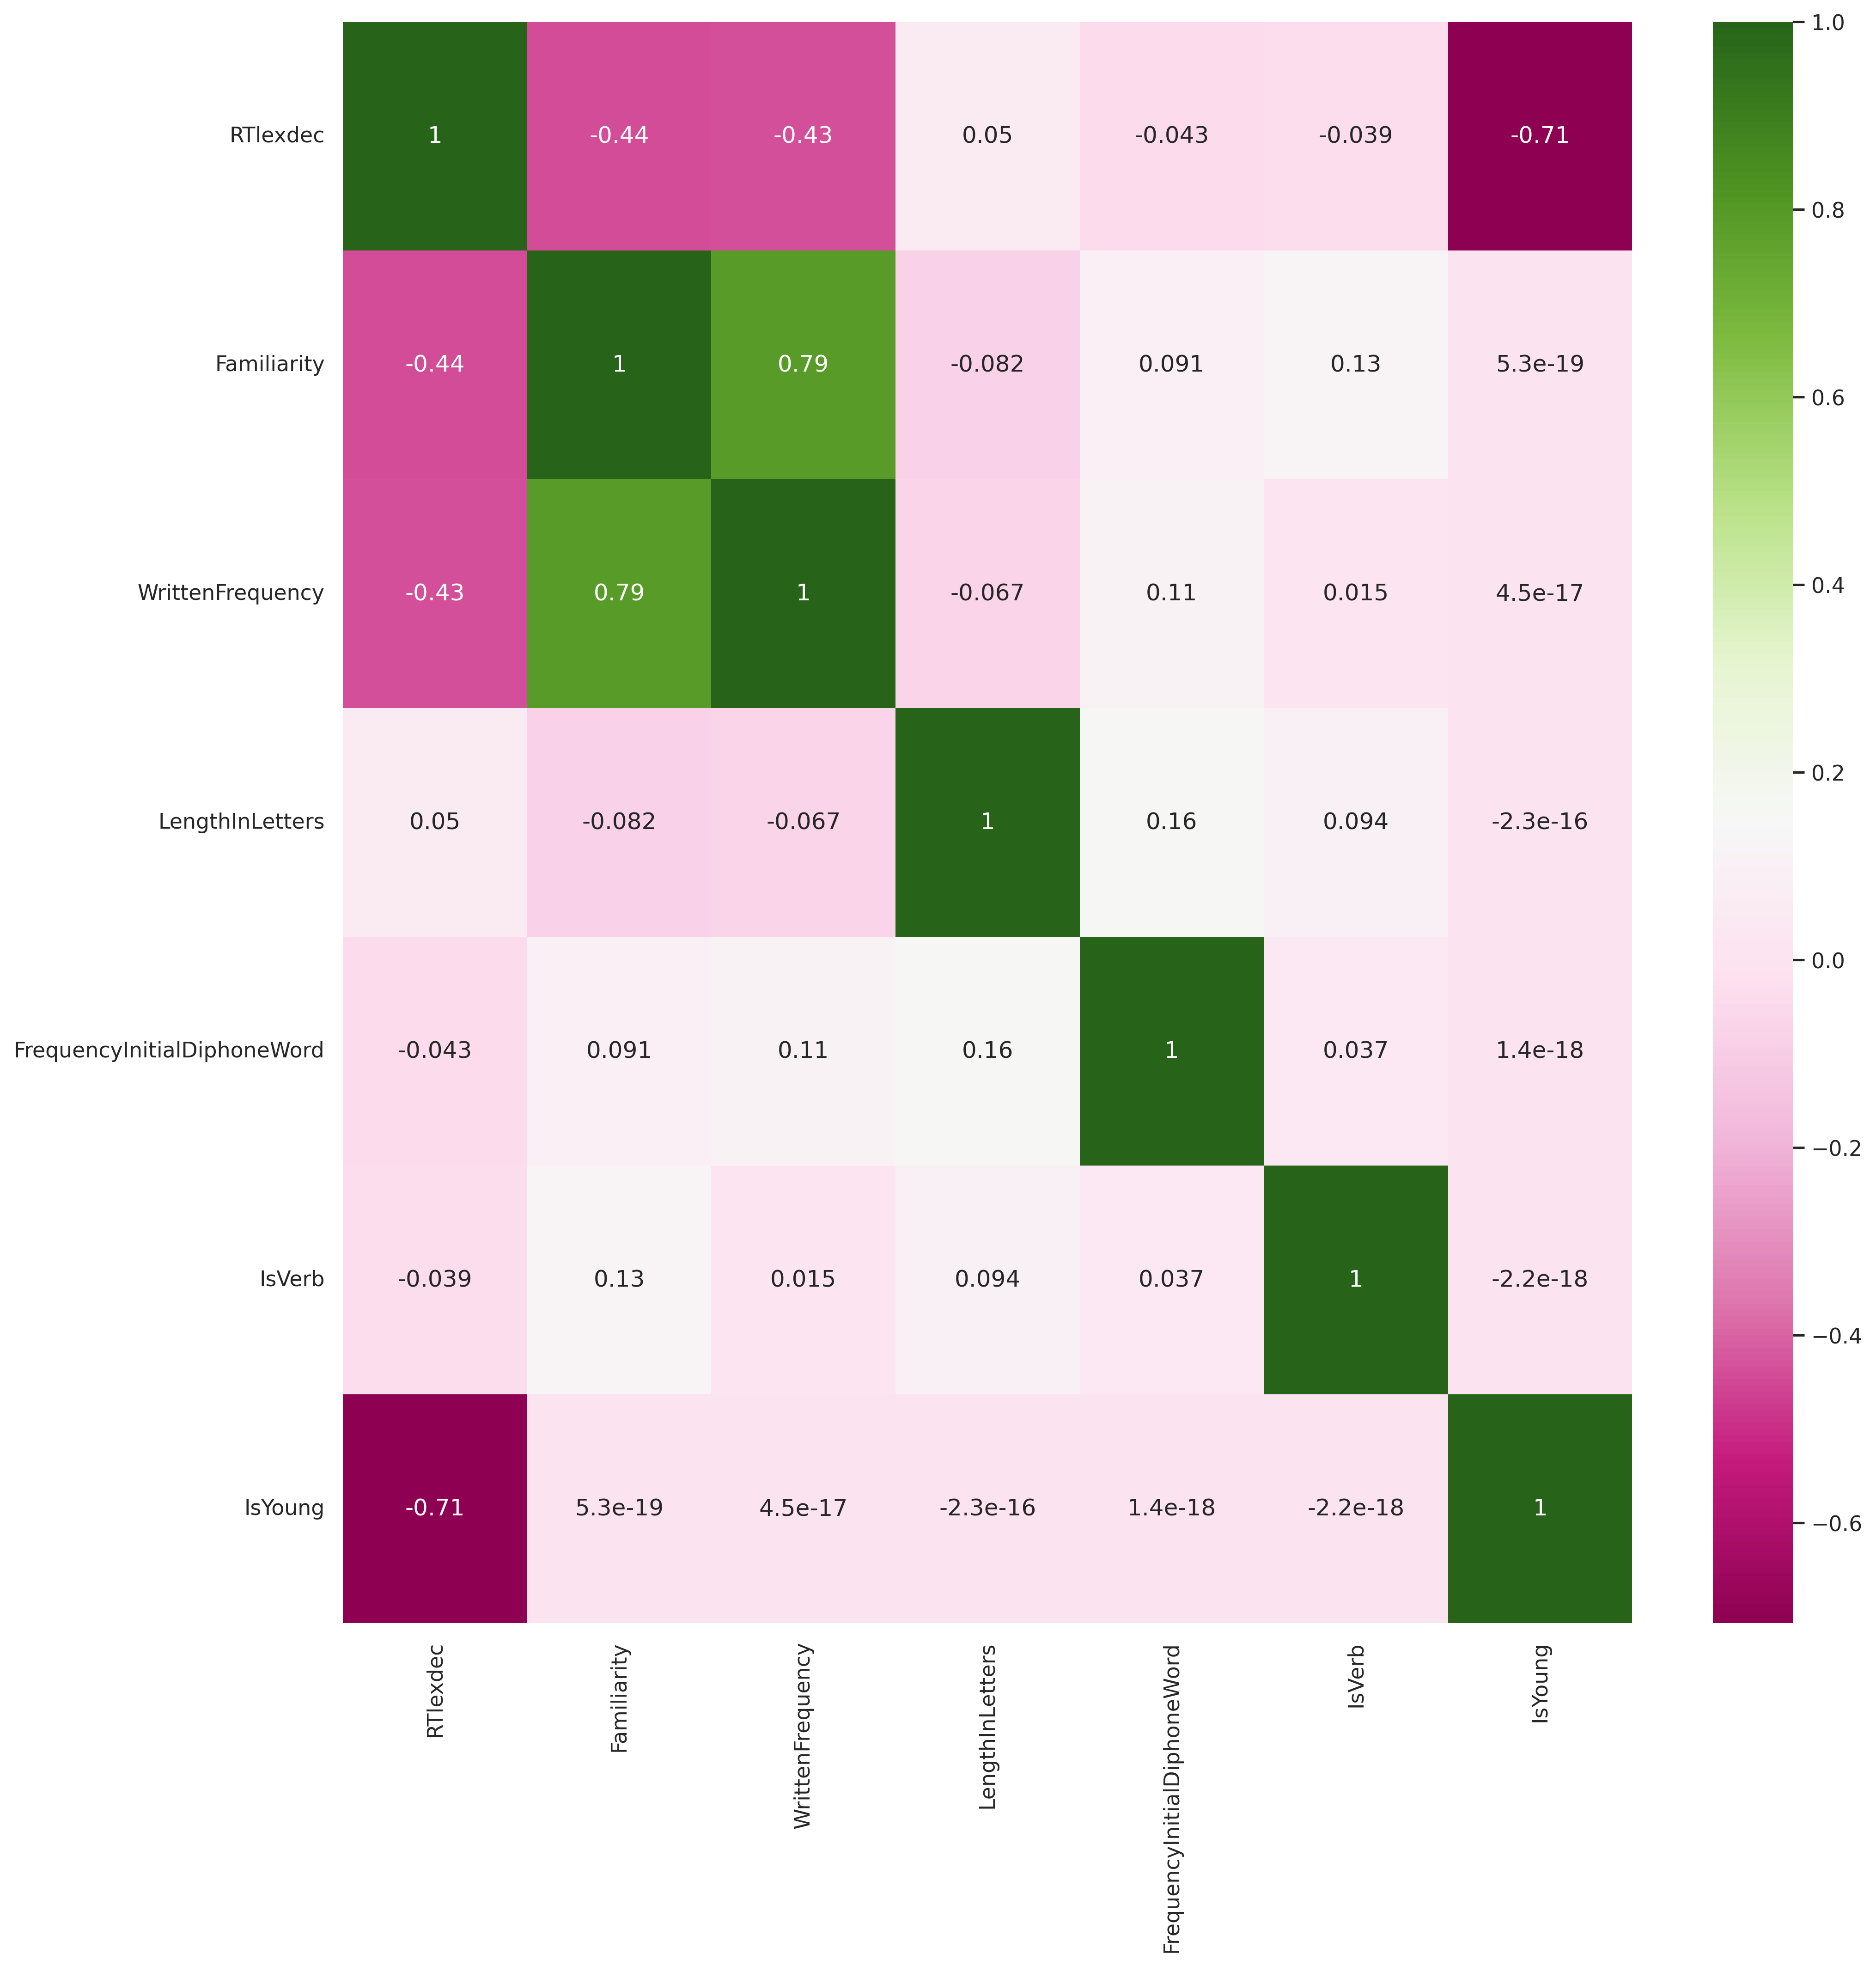

In [62]:
data = pd.DataFrame(data=df, columns=list(df.columns))
corr = data.corr()
                    
figure = plt.figure(figsize=(15, 15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='PiYG', annot=True)
plt.show()

Признаки **WrittenFrequency** и **Familiarity** сильно коррелируют между собой. Попробуем оставить только **WrittenFrequency** (проверка показала, что выбор **Familiarity** не повлияет на конечное значение <code>r2_score</code>).

Осуществим преобразование над целевой переменной. Сделаем так, чтобы для двух возрастных групп можно было отделить величину целевой переменной по некоторому threshold. Для этого введем преобразованную целевую переменную **RTFake**

In [63]:
df['RTfake'] = np.where(df['IsYoung'] == 0, 14 - df['RTlexdec'], df['RTlexdec'])

In [64]:
df.head()

RTlexdec  Familiarity  WrittenFrequency  LengthInLetters  \
4475  6.512325         4.55          6.361302                4   
1421  6.455513         4.03          4.927254                5   
926   6.457099         3.27          5.389072                4   
3077  6.516666         3.80          5.030438                3   
4482  6.566869         5.73          8.106213                4   

      FrequencyInitialDiphoneWord  IsVerb  IsYoung    RTfake  
4475                     9.779341       1        0  7.487675  
1421                    11.129011       0        1  6.455513  
926                     10.454639       0        1  6.457099  
3077                     9.444226       1        1  6.516666  
4482                     9.771441       1        0  7.433131

In [65]:
old = df.loc[(df['IsYoung'] == 0)]
young = df.loc[(df['IsYoung'] == 1)]

In [66]:
rtfake_old = old['RTfake']
rtfake_young = young['RTfake']

In [67]:
written_frequency_old = old['WrittenFrequency']
written_frequency_young = young['WrittenFrequency']

Посмотрим, как выгдядит зависимость **RTFake** от **WrittenFrequency**

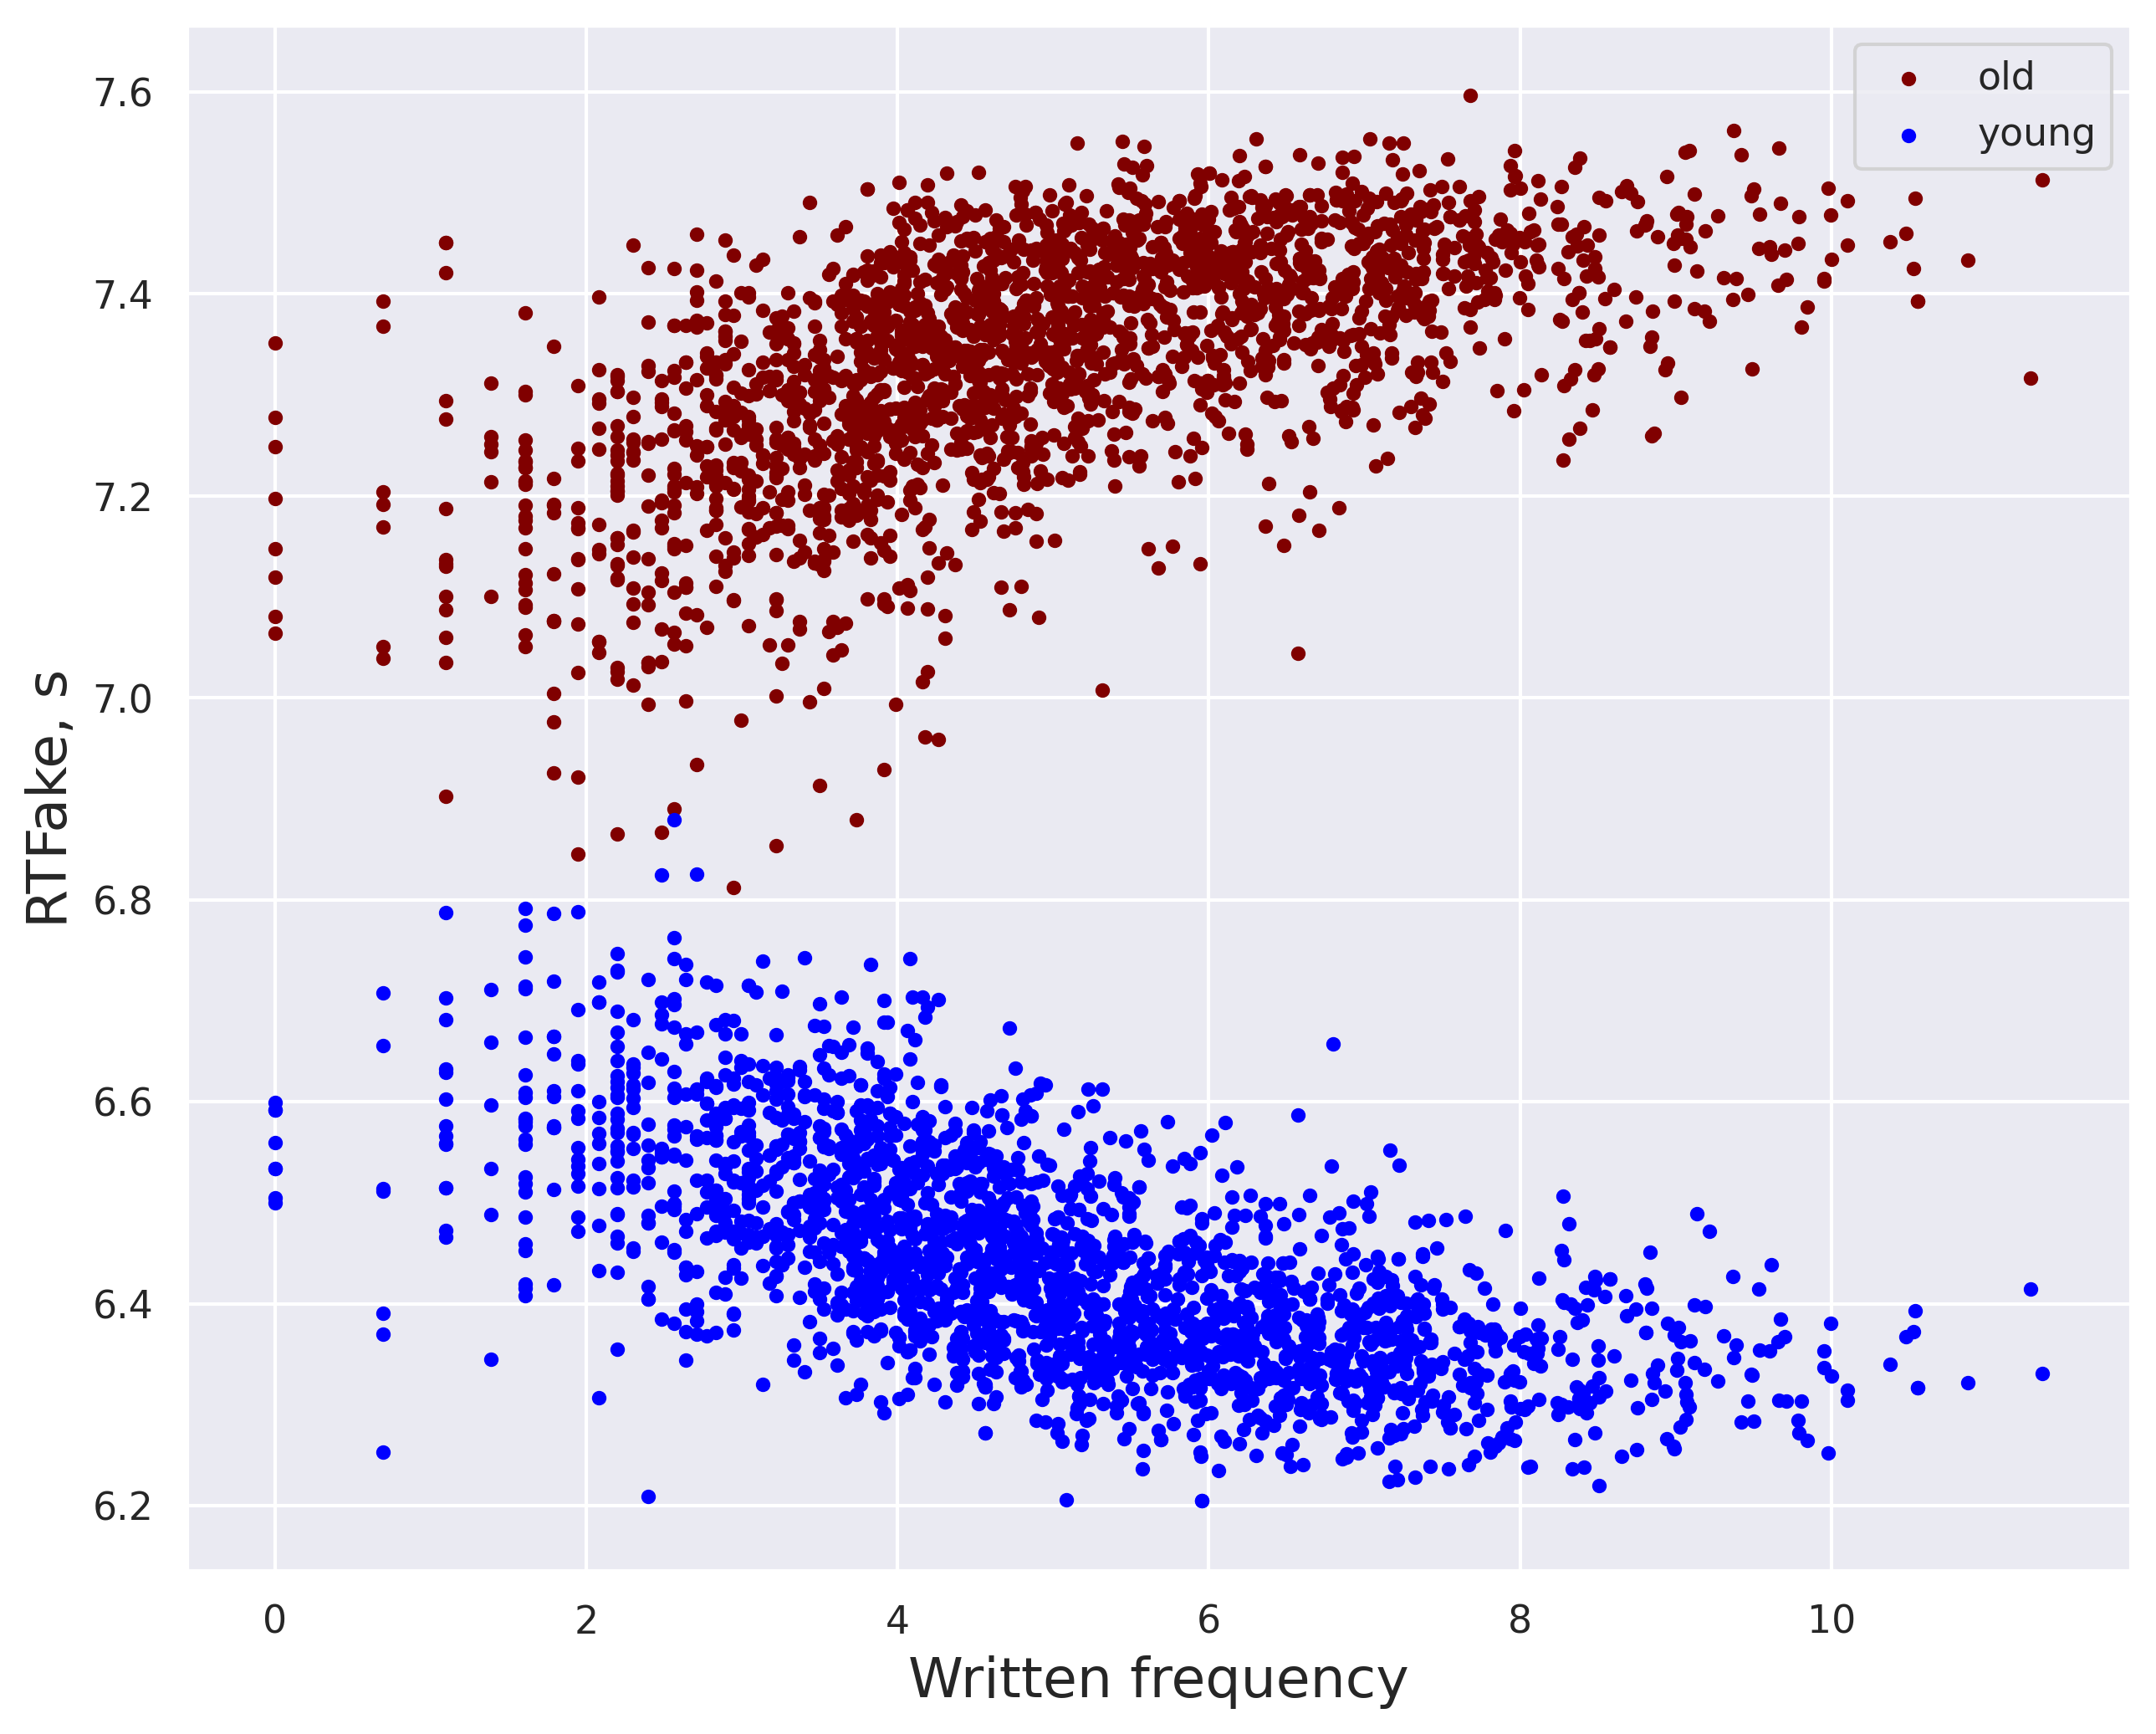

In [68]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(written_frequency_old, rtfake_old, s=10, color='maroon', label='old')
plt.scatter(written_frequency_young, rtfake_young, s=10, color='blue', label='young')
ax.set_xlabel('Written frequency', fontsize=16)
ax.set_ylabel('RTFake, s', fontsize=16)
plt.legend()
plt.show()

In [69]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

In [70]:
X_full = df_scaled[:, 1:-1]
y_full = df_scaled[:, -1]

In [71]:
X_full.shape

(4568, 6)

Оставим в рассмотрении только признаки **WrittenFrequency** и **IsYoung**

In [72]:
X_significant = np.delete(X_full, [0, 2, 3, 4], axis=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X_significant, y_full, test_size=0.2, random_state=42
)

In [74]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [75]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('MSE score on train set = ', mean_squared_error(pred_train, y_train))
print('MSE score on test set = ', mean_squared_error(pred_test, y_test))
print('R2 score on train set = ', lr.score(X_train, y_train))
print('R2 score on test set = ', lr.score(X_test, y_test))

MSE score on train set =  0.05843160184639175
MSE score on test set =  0.053345381290369774
R2 score on train set =  0.9414262783668977
R2 score on test set =  0.9471658078028697


Итак, удалось значительно улучшить качество линейной модели, сделав преобразование целевой переменной в зависимости от величины признака **AgeSubject**.

Рассмотрим мультипликативную модель, в которой **RTFake** зависит как от **WrittenFrequency** и **IsYoung** по отдельности, так и от произведения этих двух признаков (**interaction**)

In [76]:
df['MultTerm'] = df['Familiarity'] * df['IsYoung']

In [77]:
df.head()

RTlexdec  Familiarity  WrittenFrequency  LengthInLetters  \
4475  6.512325         4.55          6.361302                4   
1421  6.455513         4.03          4.927254                5   
926   6.457099         3.27          5.389072                4   
3077  6.516666         3.80          5.030438                3   
4482  6.566869         5.73          8.106213                4   

      FrequencyInitialDiphoneWord  IsVerb  IsYoung    RTfake  MultTerm  
4475                     9.779341       1        0  7.487675      0.00  
1421                    11.129011       0        1  6.455513      4.03  
926                     10.454639       0        1  6.457099      3.27  
3077                     9.444226       1        1  6.516666      3.80  
4482                     9.771441       1        0  7.433131      0.00

Для удобства изменим порядок столбцов

In [78]:
cols = df.columns.tolist()

In [79]:
cols = cols[:-2] + cols[-1:] + cols[-2:-1]
cols

['RTlexdec',
 'Familiarity',
 'WrittenFrequency',
 'LengthInLetters',
 'FrequencyInitialDiphoneWord',
 'IsVerb',
 'IsYoung',
 'MultTerm',
 'RTfake']

In [80]:
df = df[cols]
df.head()

RTlexdec  Familiarity  WrittenFrequency  LengthInLetters  \
4475  6.512325         4.55          6.361302                4   
1421  6.455513         4.03          4.927254                5   
926   6.457099         3.27          5.389072                4   
3077  6.516666         3.80          5.030438                3   
4482  6.566869         5.73          8.106213                4   

      FrequencyInitialDiphoneWord  IsVerb  IsYoung  MultTerm    RTfake  
4475                     9.779341       1        0      0.00  7.487675  
1421                    11.129011       0        1      4.03  6.455513  
926                     10.454639       0        1      3.27  6.457099  
3077                     9.444226       1        1      3.80  6.516666  
4482                     9.771441       1        0      0.00  7.433131

In [81]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

In [82]:
X_full = df_scaled[:, 1:-1]
y_full = df_scaled[:, -1]

In [83]:
X_full.shape

(4568, 7)

Оставим в рассмотрении только признаки **WrittenFrequency**, **IsYoung** и **MultTerm**.

In [84]:
X_significant = np.delete(X_full, [0, 2, 3, 4], axis=1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_significant, y_full, test_size=0.2, random_state=42
)

In [86]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [87]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('MSE score on train set = ', mean_squared_error(pred_train, y_train))
print('MSE score on test set = ', mean_squared_error(pred_test, y_test))
print('R2 score on train set = ', lr.score(X_train, y_train))
print('R2 score on test set = ', lr.score(X_test, y_test))

MSE score on train set =  0.04132852244413481
MSE score on test set =  0.03687293833694536
R2 score on train set =  0.9585709565944467
R2 score on test set =  0.9634804014172677


Удалось улучшить <code>r2_score</code>. Посмотрим на качество модели на кросс-валидации

In [88]:
from sklearn.model_selection import cross_val_score

print(f"Cross-validation score : {cross_val_score(lr, X_significant, y_full, cv=5, scoring='r2').mean()}")

Cross-validation score : 0.9594535883883983


**Результаты:**

1. Проведен однофакторный анализ. По его результатам удалось выяснить, что на значение целевой переменной **RTlexdec** сильнее всего влияют признаки **WrittenFrequency**, **Familiarity** и **AgeSubject**.

2. Регуляризация не позволила улучшить качество модели.

3. При отборе признаков были учтены результаты корреляционного анализа. Признаки **Familiarity** и **WrittenFrequency** сильно коррелируют между собой, поэтому в качестве наиболее значимых были выбраны только **IsYoung** и **WrittenFrequency**.

4. Преобразование целевой переменной позволило значительно улучшить качество линейной регрессии.

5. Введя мультипликативный член между **WrittenFrequency** и **IsYoung**, удалось также немного улучшить <code>r2_score</code>.